# Rossmann Sales Forescast

To know the history click <a href="https://www.rossmann.de/unternehmen/ueber-uns.html">Rossmann History</a> 

## 0.0. Imports

In [1]:
import pandas as pd
import inflection
import math
import datetime
import numpy as np
import pickle
import random as rd

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display  import HTML
from IPython.display       import Image
from scipy                 import stats as ss

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

### 0.1. Helper Functions

In [2]:
def cramer_v(x, y):

    # cm is Confusion Matrix
    cm = pd.crosstab(x, y).values
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    
    return np.sqrt((chi2/n) / min(k-1, r-1))


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container{width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
jupyter_settings()  


def mean_absolute_percentage_error( y, yhat ):
    return mean( np.abs( (y - yhat ) / y ) )



def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ))
    
    return pd.DataFrame( {'model_name': model_name,
                          'mae': mae,
                          'mape': mape,
                          'rmse': rmse}, index=[0])


def cross_validation(x_training, kfold, model_name, model, verbose=False):
    
    mae_list = []
    mape_list = []
    rmse_list = []
        
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKfold Number: {k}')
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        mdl = model.fit(xtraining, ytraining)

        # prediction
        yhat = mdl.predict(xvalidation)
        
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # store each result in a list
        mae_list.append(m_result['mae'])
        mape_list.append(m_result['mape'])
        rmse_list.append(m_result['rmse'])
        
        
    return pd.DataFrame({
        'model_name': model_name,
        'mae': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
        'mape': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
        'rmse': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
    }, index=[0])



Populating the interactive namespace from numpy and matplotlib


### 0.2 Loading data
Font of dataset <a href="https://www.kaggle.com/c/rossmann-store-sales/data">Kaggle Rossmann Dataset</a> and dictionary about colomns

In [3]:
# loading datasets file
df_sales_raw = pd.read_csv("dataset/train.csv")
df_store_raw = pd.read_csv("dataset/store.csv")

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on='Store')

/home/python/PycharmProjects/Projects/rossmann_sales_forecast/venv_rossmann/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 1.0. Data Description

In [8]:
# copy data from original data
df1 = df_raw.copy()

### 1.1. Rename Columns

In [9]:
# get the name of columns
cols_old = df1.columns

See the documentation the <a href="https://inflection.readthedocs.io/en/latest/">Inflection Snakecase</a>

In [10]:
# transform snakecase with inflection
snakecase = lambda x: inflection.underscore(x)
cols_new = map(snakecase, cols_old)
# replace the columns
df1.columns = cols_new

### 1.2. Data Dimensions

In [11]:
# See the dimensions to know if we have a computing enough to run
print(f"Number of Rows: {df1.shape[0]}")
print(f"Number of Columns: {df1.shape[1]}")

# In this case ok, my computer can run

Number of Rows: 1017209
Number of Columns: 18


### 1.3. Data Types 

In [12]:
# See types of each data and if will be necessary converting or not
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [13]:
# this case we have columns
# date = object (must be datetime)
# competition_open_since_year = float -> int
# competition_open_since_month = float -> int
# promo2_since_week = float -> int

# It's not possible convert to int because there are NaN, first let's fillna, after I will chage types
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [14]:
# only we will change it's data, because we must have date form to replace NaN the others columns

# date from object to datetime
df1['date'] = pd.to_datetime(df1.date).copy()

In [15]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
132890,206,5,2015-04-03,0,0,0,1,b,1,a,c,380.0,NaN,NaN,1,14.0,2012.0,"Jan,Apr,Jul,Oct"
145657,708,1,2015-03-23,4366,430,1,0,0,0,c,c,11470.0,10.0,2009.0,1,18.0,2014.0,"Jan,Apr,Jul,Oct"
772896,987,4,2013-08-08,5749,831,1,0,0,0,c,a,1690.0,6.0,2007.0,0,NaN,NaN,NaN
611882,533,1,2013-12-30,12271,1085,1,0,0,1,a,c,5950.0,NaN,NaN,0,NaN,NaN,NaN
742561,757,3,2013-09-04,4115,407,1,0,0,1,a,c,3450.0,NaN,NaN,0,NaN,NaN,NaN


In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4. Check NaN 

In [17]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5. Fillout NaN

#### 1.5.0 Review

    competition_distance
    If the competitors is nan, maybe there aren't competitors closer, others words, they are so far a way, well, 
    this case make a sence replace the value up the max value it's the same, but with values
        max() == 75860.0 I will replace to 200000.0

    competition_open_since_month
    competition_open_since_year
    promo2_since_week
    promo2_since_year
        This options above we will get from date the year, month and week to try the first solution, because
        there are many NaN and we will replace from date
        
    promo_interval
        If this columns contains any informations, it means that the store joined the promo2 else if this columns
        is empt it means that the store not joined the promo2, I will make comparison between 
        promo_interval and month from date, when if month contain in promo_interval it means promo2 == 1 else 
        promo2 == 0

#### 1.5.1. competition_distance

In [18]:
# Getting the max value from columns
max_value = df1['competition_distance'].max()
# calculate base on 200000.0 to automate % and rounded to up
val_repl_comp_dist = round(
    ((((200000.0 - max_value) / max_value) + 1) * max_value))
# replace the NaN to 200000.0 or defaut % up from max()
df1['competition_distance'] = df1['competition_distance'].fillna(
    val_repl_comp_dist)

In [19]:
# this way it's harder than fillna() and lesser performance
    # df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) == True else x)

#### 1.5.2. competition_open_since_month 
    competition_open_since_year
    promo2_since_week
    promo2_since_year

In [20]:
# Second Cycle
# the solution that Meigaron had it's not a ideal, because if you seeing the index == 522152 bellow
# see that imagine if competition had been NaN, the data is:
#  	 date    	day_of_week 	competition_open_since_month 	competition_open_since_year 	promo2_since_week 	promo2_since_year
# 2014-03-20  	    4       	           3.0              	         2014.0             	       3.0      	     2014
# as you see, all diferent from the real, but to first solution, we will be try, after we will try other way

# see at bellow code
#df1[['date', 'day_of_week', 'competition_open_since_month', 
#    'competition_open_since_year', 'promo2_since_week', 
#    'promo2_since_year']][df1.index == 522152]

In [21]:
# replacing the NaN with day, week, month and year from date, it's suppose to date
# is beggining the competition between sotores

# competition_open_since_month
df1['competition_open_since_month'] = df1[
    'competition_open_since_month'].fillna(df1.date.dt.month)

# competition_open_since_year
df1['competition_open_since_year'] = df1[
    'competition_open_since_year'].fillna(df1.date.dt.year)

# promo2_since_week
df1['promo2_since_week'] = df1['promo2_since_week'].fillna(
    df1.date.dt.dayofweek)

# promo2_since_year
df1['promo2_since_year'] = df1['promo2_since_year'].fillna(
    df1.date.dt.year)

#### 1.5.3. promo_interval

In [22]:
# this map is to replace number to your value, exemple, 2:'Feb' where has the number 2 will be replace to 'Feb'
month_map = {
    1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
    7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'
}
# replace number to month name with map()
df1['month_map'] = df1['date'].dt.month.map(month_map)

# replace the NaN to zero "0" at the column promo_interval
df1['promo_interval'].fillna(0, inplace=True)

# run each line and it's verify if month_map contains in promo_interval
# return 1 to new columns ['is_promo']
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in
    x['promo_interval'].split(',') else 0, axis=1)

In [23]:
# Second Cycle

# df1.sample(10)
# first of all we will replace the promo_interval to number or..
# create a new column with month name and compare

# this head will be to view a comparation before than after alteration and see if run
#df1.head(20)

# see if the value in month_map contains in promo_interval if is true than replace promo2 to 1 else
# replace to 0
#df1['is_promo'] = df1[['promo2', 'promo_interval', 'month_map']].apply(
#    lambda x: 1 if x['promo2'] == 1 else 1 if x['month_map'] in str(x['promo_interval']).split(',') else 0, axis=1)

# this is the next cycle, because I think that the Meigaron Ideia it's not right, but we will run the way
# from him and after run this solution and compere the score between them.
#df1[['date', 'promo', 'promo2', 'promo2_since_year', 
#     'promo_interval', 'month_map', 'is_promo']][df1.index == 12]

### 1.6. Change Types

In [24]:
# convert object to integer
df1['competition_open_since_month'] = df1[
    'competition_open_since_month'].astype(int)

# convert object to integer
df1['competition_open_since_year'] = df1[
    'competition_open_since_year'].astype(int)

# convert object to integer
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

# convert object to integer
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.7. Descriptive Statistical

In [25]:
# Slicing datatype by numerical and categorical data, first of all we need see dtypes

# to show kind of dtypes
df1.dtypes.value_counts()

int64             13
object             5
datetime64[ns]     1
float64            1
dtype: int64

In [26]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(
    exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.7.1 Numerical

In [27]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


In [28]:
# Central Tendency - mean, median
ct_mean = pd.DataFrame(num_attributes.mean())
ct_median = pd.DataFrame(num_attributes.median())

In [29]:
# Dispersion - std, min, max, range, skew, kurtosis

d_std = pd.DataFrame(num_attributes.std())
d_min = pd.DataFrame(num_attributes.min())
d_max = pd.DataFrame(num_attributes.max())
d_range = pd.DataFrame(d_max - d_min)
d_skew = pd.DataFrame(num_attributes.skew())
d_kurtosis = pd.DataFrame(num_attributes.kurtosis())

In [30]:
# Concatenation Metrics
metrics = pd.concat(
    [d_min, d_max, d_range, ct_mean, ct_median, d_std, d_skew, d_kurtosis],
    axis=1).reset_index()

metrics.columns = [
    'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew',
    'kurtosis'
]

In [31]:
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.652996,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311087,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515593,-7.235657,124.071304


<AxesSubplot:xlabel='sales'>

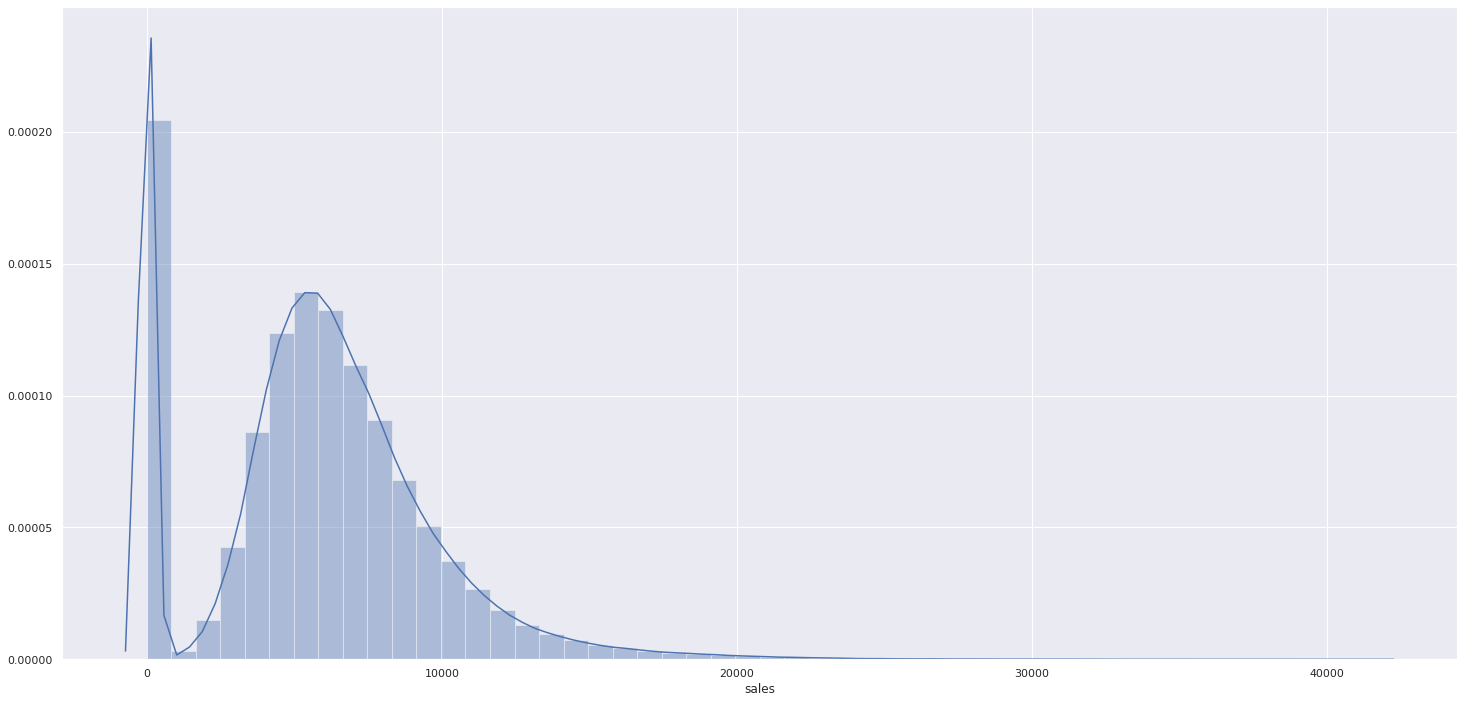

In [32]:
# Sales Distribution
sns.distplot(df1['sales'])

# as you see the most of volum of sales it's closer of zero, why?

#### 1.7.2 Categorical

In [33]:
cat_attributes.describe(include='all')

,state_holiday,store_type,assortment,promo_interval,month_map
count,1017209,1017209,1017209,1017209,1017209
unique,5,4,3,4,12
top,0,a,a,0,Mar
freq,855087,551627,537445,508031,103695


In [34]:
#sns.boxplot(x='state_holiday', y='sales', data=df1)
# as you see that's impossible understand something, probably because the range it's so long and there are
# a "0" in the state_holiday, it's possible in that state_holiday==0 is close store, let's get off the 0

In [35]:
aux_filt_sh = df1[(df1['state_holiday'] != 0)&(df1['state_holiday'] != '0')]                 

In [36]:
#sns.boxplot(x='state_holiday', y='sales', data=aux_filt_sh)

# this case it's not solve the problem because the sales it's most closer at '0', in this case I think one solution is
# do filter when take above '0' otherwords up of zero it's like a (sale > zero), let's try

count of each


a    694
b    145
c     71
Name: state_holiday, dtype: int64

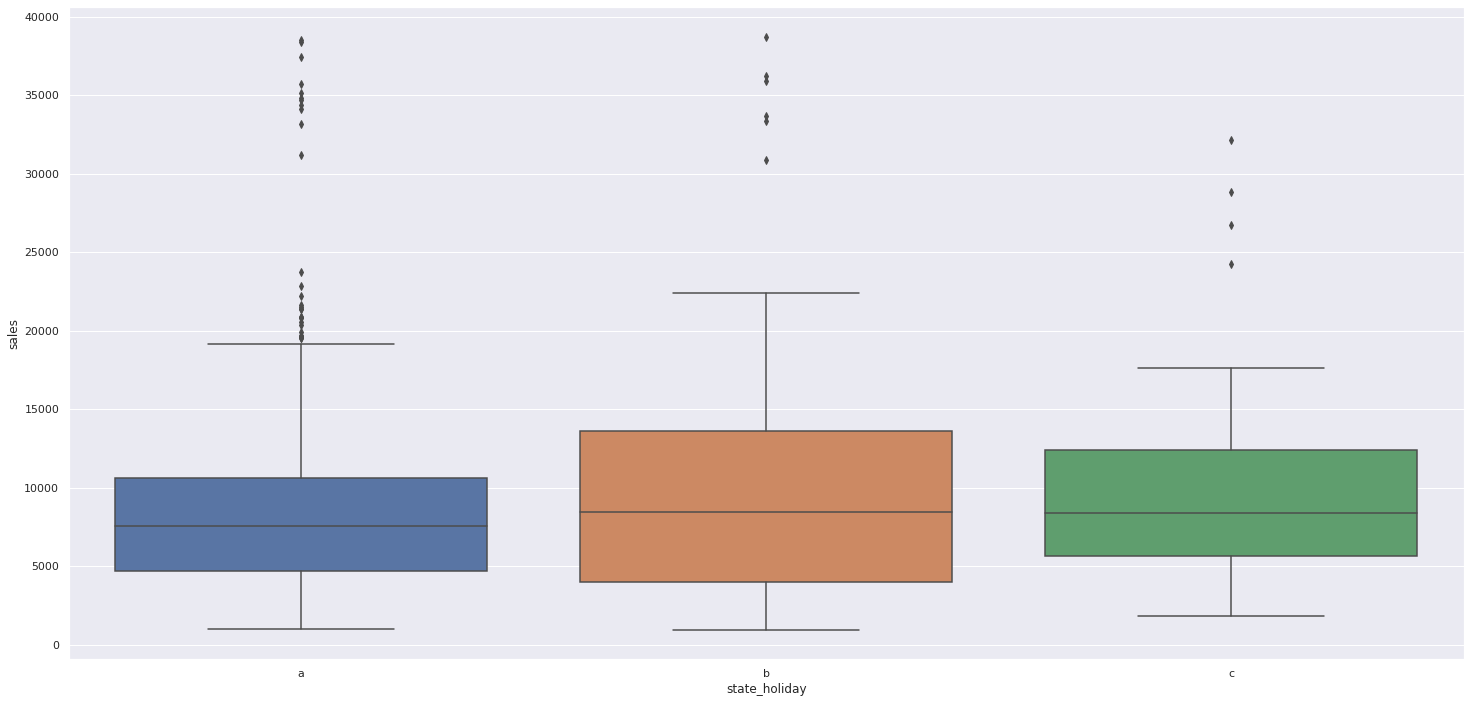

In [37]:
sns.boxplot(x='state_holiday', y='sales', data=aux_filt_sh[aux_filt_sh.sales > 0])
print('count of each')
aux_filt_sh['state_holiday'][aux_filt_sh.sales > 0].value_counts()

# OK! that's right now, but let's compare the others categorical columns

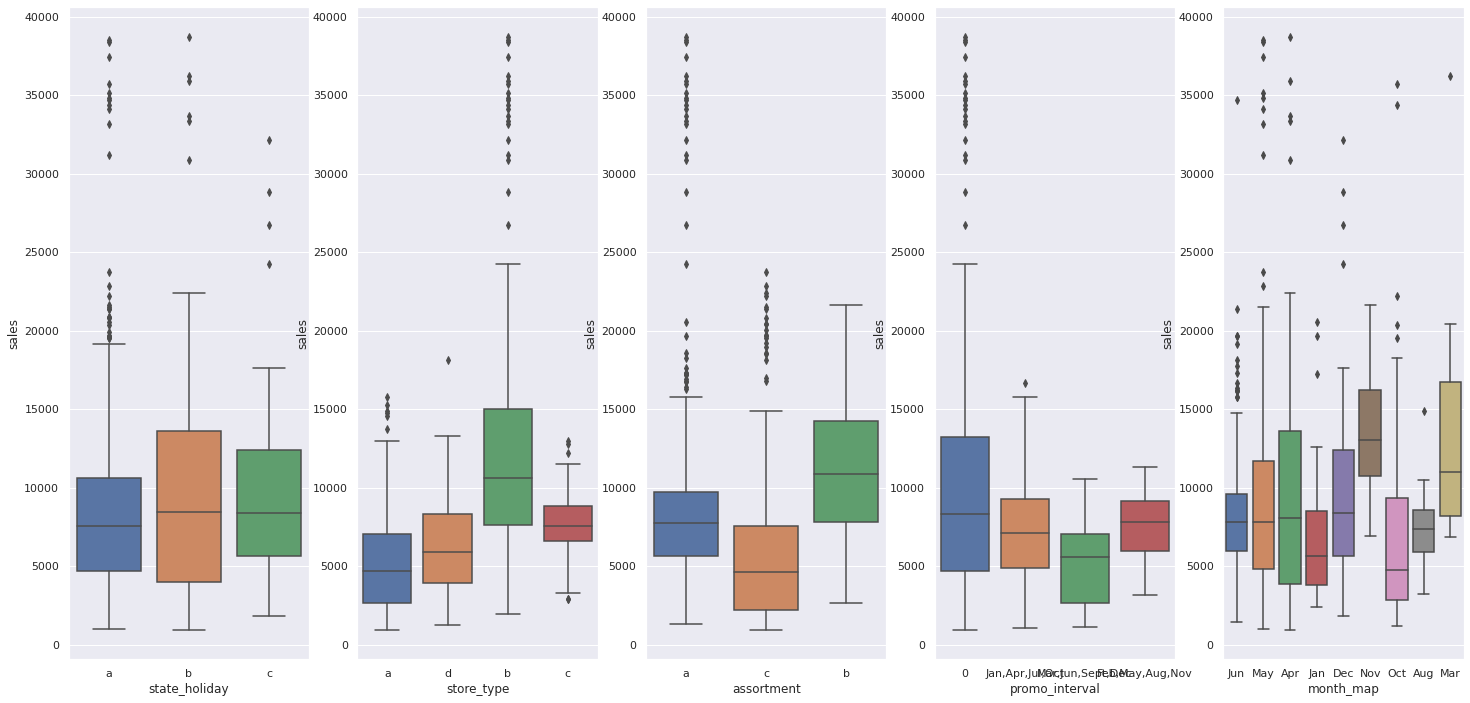

In [38]:
# plotting filtering only holidays, otherwords, nothing a normal days and sales up than zero (sales > 0)
cont = 1
for cat in cat_attributes.head():
    plt.subplot(1, cat_attributes.shape[1], cont)
    sns.boxplot(x=cat, y='sales', data=aux_filt_sh[aux_filt_sh.sales > 0])
    cont += 1

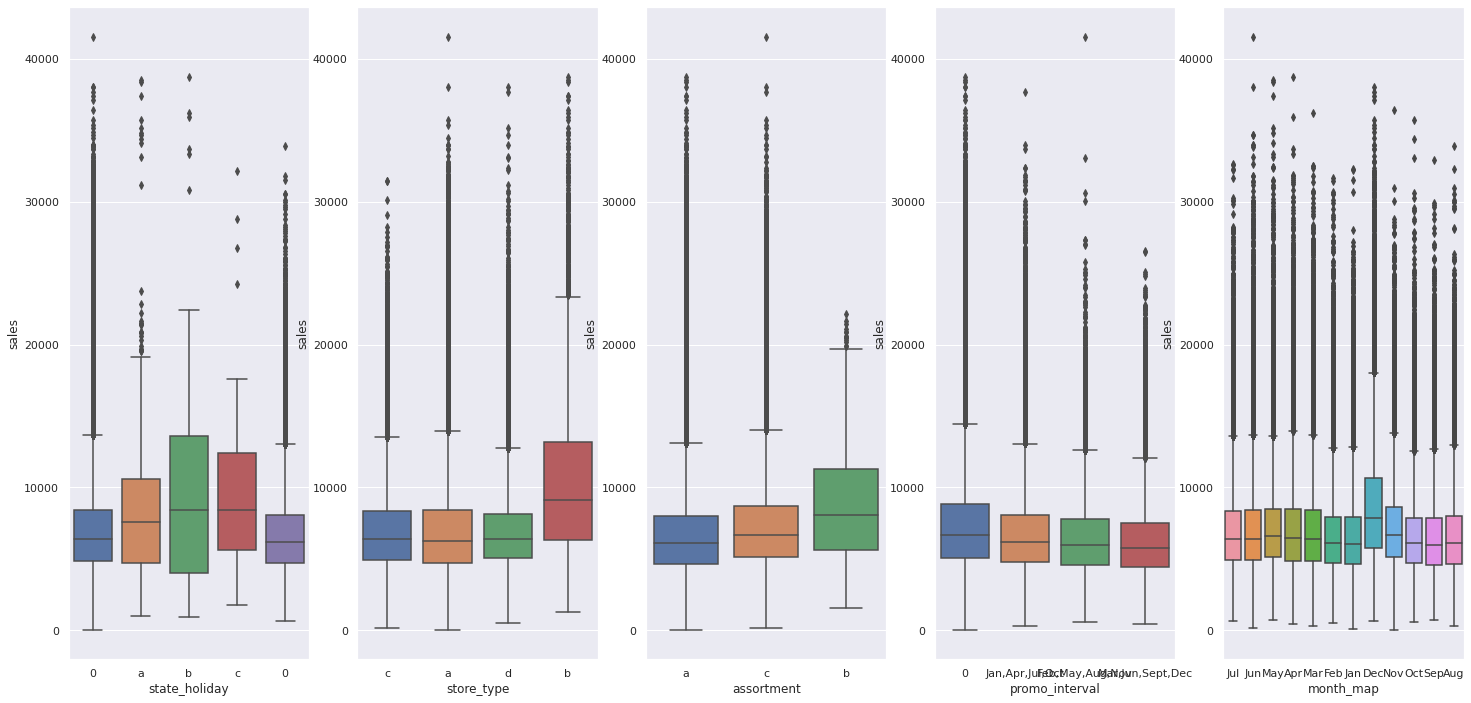

In [39]:
# Let's see bellow the total data to compare with only holidays above ^
cont = 1
for cat in cat_attributes.head():
    plt.subplot(1, cat_attributes.shape[1], cont)
    sns.boxplot(x=cat, y='sales', data=df1[df1['sales'] > 0])
    cont += 1

## 2.0. Feature Engineering

### 2.1. Hypothesis Mind Map

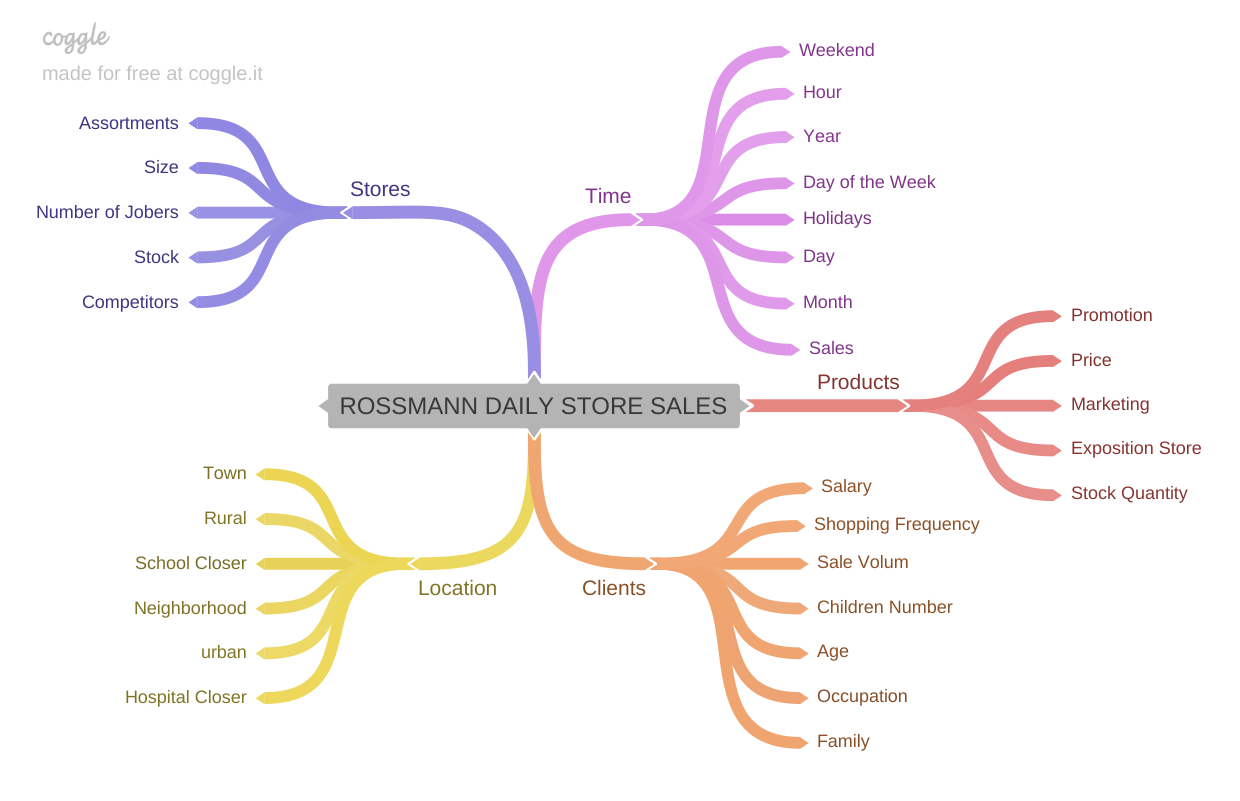

In [40]:
# MindMap to possible hyphotesis list
# Importing Mid Map builded in the coggle site
Image('img/rossamann_mid_map_hypothesis.png')

# To build a Hyphotesis MindMap you will must three asks
# 1-> Fenomeno | 2->Agents or Entities | 3->Attributes

### 2.2. Building Hypothesis List

#### 2.2.1. Store

<input type="checkbox" checked> **_1.** It's supposed to more assortments more sale

<input type="checkbox">**_2.** It's supposed to how much bigger store, more sale

<input type="checkbox">**_3.** It's supposed to how much more a numbers of employers, more sale

<input type="checkbox">**_4.** It's supposed how much more stock more sale

<input type="checkbox" checked>**_5.** It's supposed to how more distance from competitors, more sale



#### 2.2.2. Products

<input type="checkbox"> **1.** It's supposed to how much more investments in marketing, more sale

<input type="checkbox"> **2.** It's supposed to how much exposition products, sale more

<input type="checkbox"> **3.** It's supposed to how much product lesser price, more sale

<input type="checkbox"> **4.** It's supposed to how much more discounts or agressive promotion, more sale

#### 2.2.3. Time

<input type="checkbox" checked> **1.** It's supposed to on the weekend you will sales less

<input type="checkbox"> **2.** It's supposed to on the night sale more

<input type="checkbox"> **3.** It's supposed to there are a cycle each year that sale more and less

<input type="checkbox"> **4.** It's supposed to on the monday sale more

<input type="checkbox"> **5.** It's supposed to on the holidays sale less

<input type="checkbox"> **6.** It's supposed to on days that the clients recieve the salary, sale more

<input type="checkbox"> **7.** It's supposed to on the months in the winter sale more

<input type="checkbox"> **8.** It's supposed to on the end's month sale more because the "on-sale" promotion

<input type="checkbox" checked> **9.** It's supposed to the store open in the christmas holiday sale more

<input type="checkbox" checked> **10.** It's supposed to how much older the store, more sale

<input type="checkbox" checked> **11.** It's supposed to sale more in the second semester

<input type="checkbox" checked> **12.** It's supposed to sale more after day 10 from each month

<input type="checkbox" checked> **13.** It's supposed to holidays school sale less

<input type="checkbox" checked> **14.** It's supposed to how much more long time competitors, more sale

<input type="checkbox" checked> **15.** It's supposed to how much longer time promotion active, more sale

<input type="checkbox" checked> **16.** It's supposed to how much days in promotion, more sale

<input type="checkbox" checked> **17.** It's supposed to how much consecutives promotion, more sale

#### 2.2.3. Clients

<input type="checkbox"> **1.** It's Supposed to how much bigger salary less sale

<input type="checkbox"> **2.** It's supposed to how much more class "C", more sale <a href="https://www.ictq.com.br/varejo-farmaceutico/405-perfil-do-consumidor-de-medicamentos">Article Font Link</a> 

<input type="checkbox"> **3.** It's supposed to female buy more than male <a href="https://www.ictq.com.br/varejo-farmaceutico/405-perfil-do-consumidor-de-medicamentos">Article Font Link</a>

<input type="checkbox"> **4.** It's supposed to how much more frequency more sale

<input type="checkbox"> **5.** It's supposed to how much more mean ticket, more sale

<input type="checkbox"> **6.** It's supposed to how much more volum sale, more sale

<input type="checkbox"> **7.** It's supposed to how children, more sale

<input type="checkbox"> **8.** It's supposed to how much more age, more sale

<input type="checkbox"> **9.** It's supposed to how much more simple occupation client, more sale

<input type="checkbox"> **10.** It's supposed to how much more degree graduation, less sale <a href="https://www.ictq.com.br/varejo-farmaceutico/405-perfil-do-consumidor-de-medicamentos">Article Font Link</a>

<input type="checkbox"> **11.** It's supposed to how much more members from family, more sale

#### 2.2.5. Location

<input type="checkbox"> **1.** It's supposed to store location is in a town, more sale

<input type="checkbox"> **2.** It's supposed to how much closer store by hospital, more sale

<input type="checkbox"> **3.** It's supposed to how much closer school, more sale

<input type="checkbox"> **4.** It's supposed to how much the neighborhood closer by town, more sale

<input type="checkbox"> **5.** It's supposed to hurban store saler more than rural

### 2.3. Priority Hypothesis List

<input type="checkbox" checked> **1.** It's supposed to stores that has more assortments more sale

<input type="checkbox" checked> **2.** It's supposed to how less competitors closer, more sale

<input type="checkbox" checked> **3.** It's supposed to how much more long time competitors, more sale

<input type="checkbox" checked> **4.** It's supposed to how much longer time promotion active, more sale

<input type="checkbox"> **5.** It's supposed to how much days in promotion, more sale

<input type="checkbox" checked> **6.** It's supposed to how much consecutives promotion, more sale

<input type="checkbox" checked> **7.** It's supposed to the store open in the christmas holiday sale more

<input type="checkbox" checked> **8.** It's supposed to sale more along the years

<input type="checkbox" checked> **9.** It's supposed to sale more in the second semester

<input type="checkbox" checked> **10.** It's supposed to sale more after day 10 from each month

<input type="checkbox" checked> **11.** It's supposed to on the weekend you will sales less

<input type="checkbox" checked> **12.** It's supposed to holidays school sale less

### 2.4. Feature Engineering

#### 2.4.1 Derivates Features

In [41]:
# New dataframe to build features
df2 = df1.copy()

# year
df2['year'] = df1['date'].dt.year

# month
df2['month'] = df1['date'].dt.month

# day
df2['day'] = df1['date'].dt.day

# week of year
df2['week_of_year'] = df1['date'].dt.weekofyear

# year week
df2['year_week'] = df1['date'].dt.strftime('%Y-%W')

In [42]:
# competition since
df2['competition_since'] = df1.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df1['date'] - df2['competition_since'])/30).apply( lambda x: x.days )

In [43]:
# promo since
df2['promo_since'] = df1['promo2_since_year'].astype( str 
    ) +'-'+ df1['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply(
    lambda x: datetime.datetime.strptime( 
    x +'-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))

# since time week in promotion
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days ).astype( int )

In [44]:
# assortments
df2['assortment'] = df1['assortment'].map({'a':'basic', 'b':'extra', 'c':'extended'})

In [45]:
# state holiday
map = {
    '0':'regular_day',
    'a':'public_holiday',
    'b':'easter_holiday',
    'c':'christmas'
}

df2['state_holiday'] = df1['state_holiday'].map(map)

In [46]:
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
105761,952,2,2015-04-28,6346,481,1,1,regular_day,0,d,extended,6300.0,10,2013,0,1,2015,0,Apr,0,2015,4,28,18,2015-17,2013-10-01,19,2014-12-29,17
409760,226,7,2014-06-29,0,0,0,0,regular_day,0,a,basic,450.0,6,2014,0,6,2014,0,Jun,0,2014,6,29,26,2014-25,2014-06-01,0,2014-02-03,20
734634,635,3,2013-09-11,6509,647,1,1,regular_day,0,a,basic,27530.0,4,2014,0,2,2013,0,Sep,0,2013,9,11,37,2013-36,2014-04-01,-7,2013-01-07,35
556192,593,2,2014-02-18,10403,1222,1,1,NaN,0,a,extended,33060.0,3,2010,0,1,2014,0,Feb,0,2014,2,18,8,2014-07,2010-03-01,48,2013-12-30,7
807587,1113,1,2013-07-08,5096,611,1,0,regular_day,1,a,extended,9260.0,7,2013,0,0,2013,0,Jul,0,2013,7,8,28,2013-27,2013-07-01,0,2012-12-24,28


## 3.0. Variables Filters

In [47]:
# copy from df2
df3 = df2.copy()

<h6>Business Restriction</h6>
<table align="left" style="width:100%">
    <tr>
        <th>Columns</th>
        <th>Restriction</th>
        <th>Doing Now</th>
        <th>Future Solution</th>
        <th>--------</th>
    </tr>
    <tr>
        <td>Customers</td>
        <td>We don't have this data on the production</td>
        <td>Left out</td>
        <td>Make a prediction to get the value</td>
        <td>--------</td>
    </tr>
    <tr>
        <td>Open</td>
        <td>Filtered only one information</td>
        <td>Left out</td>
        <td>--------</td>
        <td>--------</td>
    </tr>
    <tr>
        <td>Promo Interval</td>
        <td>Derivated</td>
        <td>Left out</td>
        <td>--------</td>
        <td>--------</td>
    </tr>
    <tr>
        <td>Month Map</td>
        <td>Derivated</td>
        <td>Left out</td>
        <td>--------</td>
        <td>--------</td>
    </tr>
</table>

### 3.1 Lines Filters

In [48]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2. Columns Selection

In [49]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [50]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 4.0. Data Exploratory

### 4.0.1 Review

<li>Gain Business Experience</li>
<li>Hypothesis Validation (Insights)</li>
<li>Variables Perception to Modeling</li>

<h4>Three types of Exploratory Data Analysis</h4>
<li>Univariate Analysis</li>
<li>Bivariate Analysis</li>
<li>Multivariate Analysis</li>

In [51]:
# Copy from Data Frame df3
df4 = df3.copy()

### 4.1. Univariate Analysis

#### 4.1.1 Response Variable

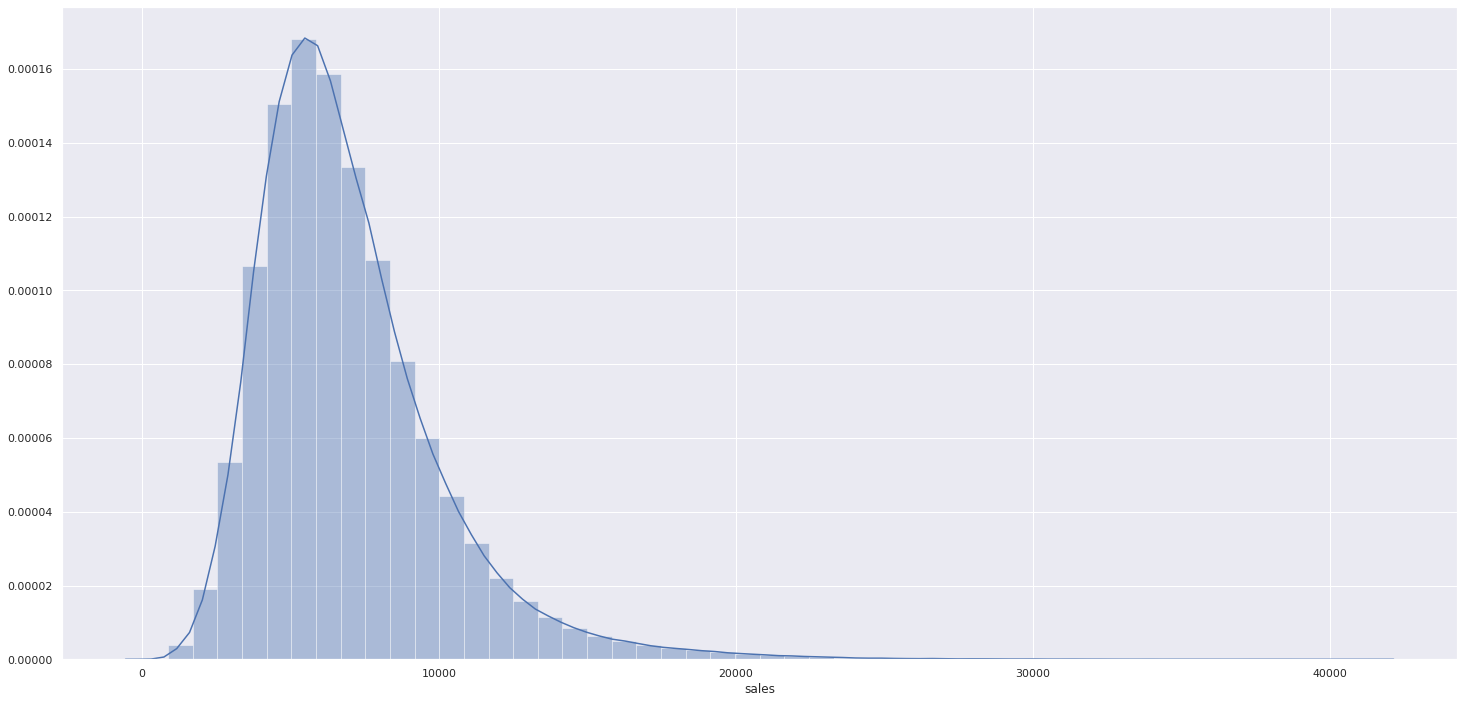

In [52]:
sns.distplot(df4['sales']);

#### 4.1.2 Numerical Variable

This is the original data df1

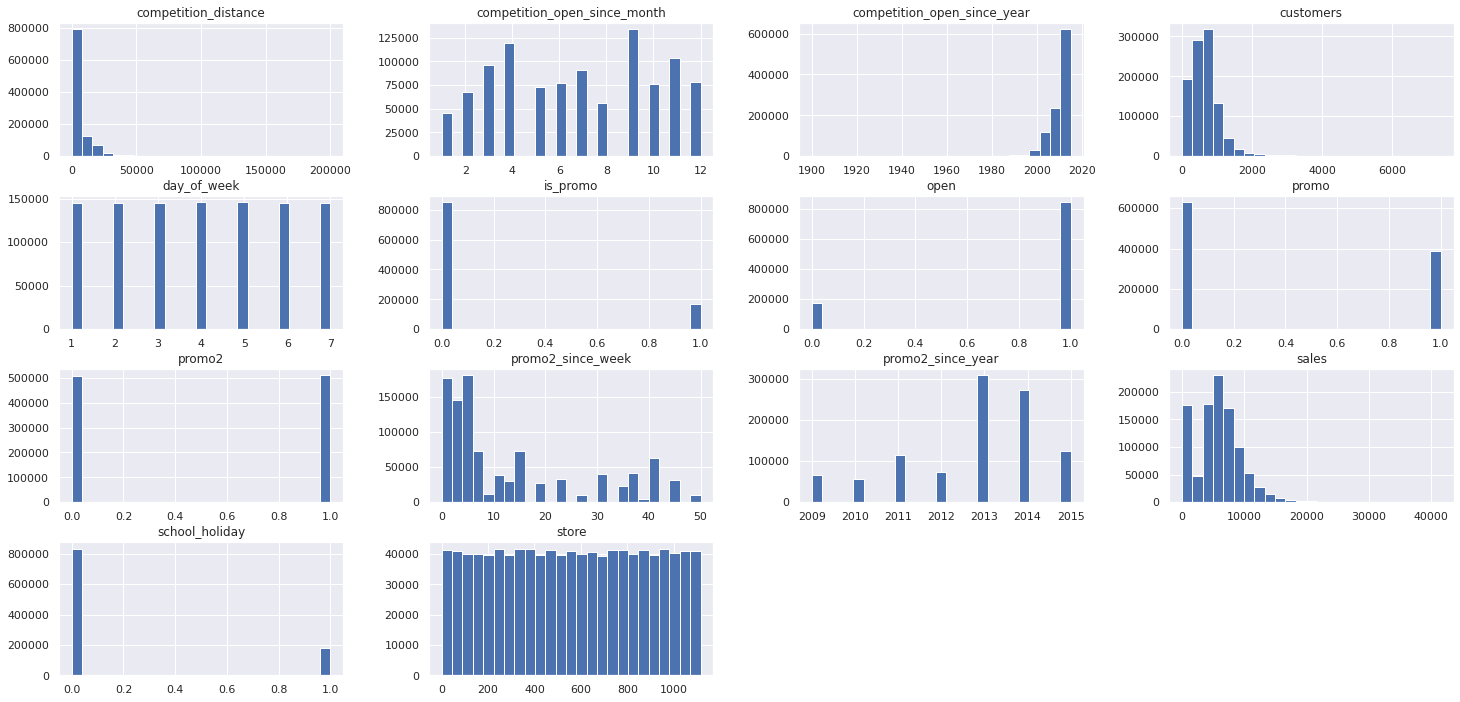

In [53]:
# atributes from df1
num_attributes.hist(bins=25);

This is the filtered data by sale > 0 and store opened

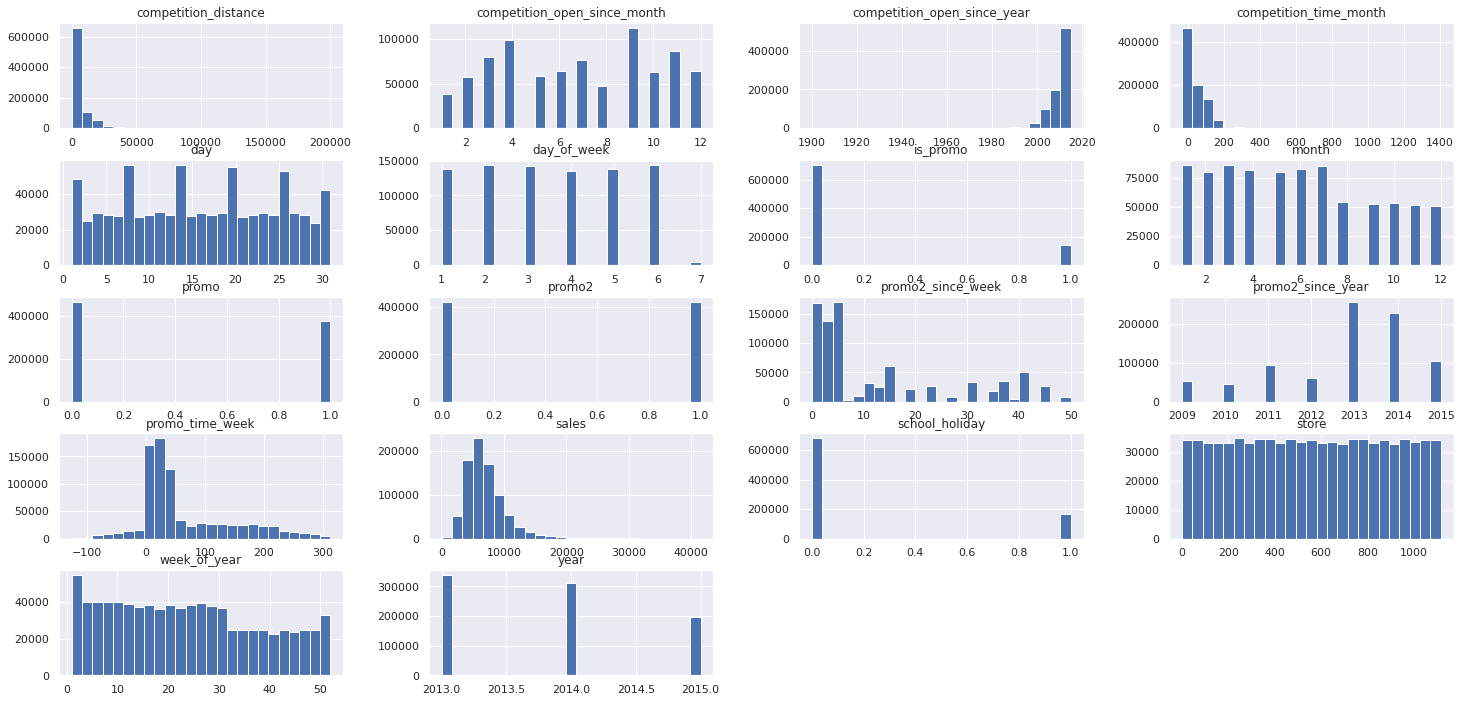

In [54]:
# atributes from df4
df4.select_dtypes(exclude='object').hist(bins=25);

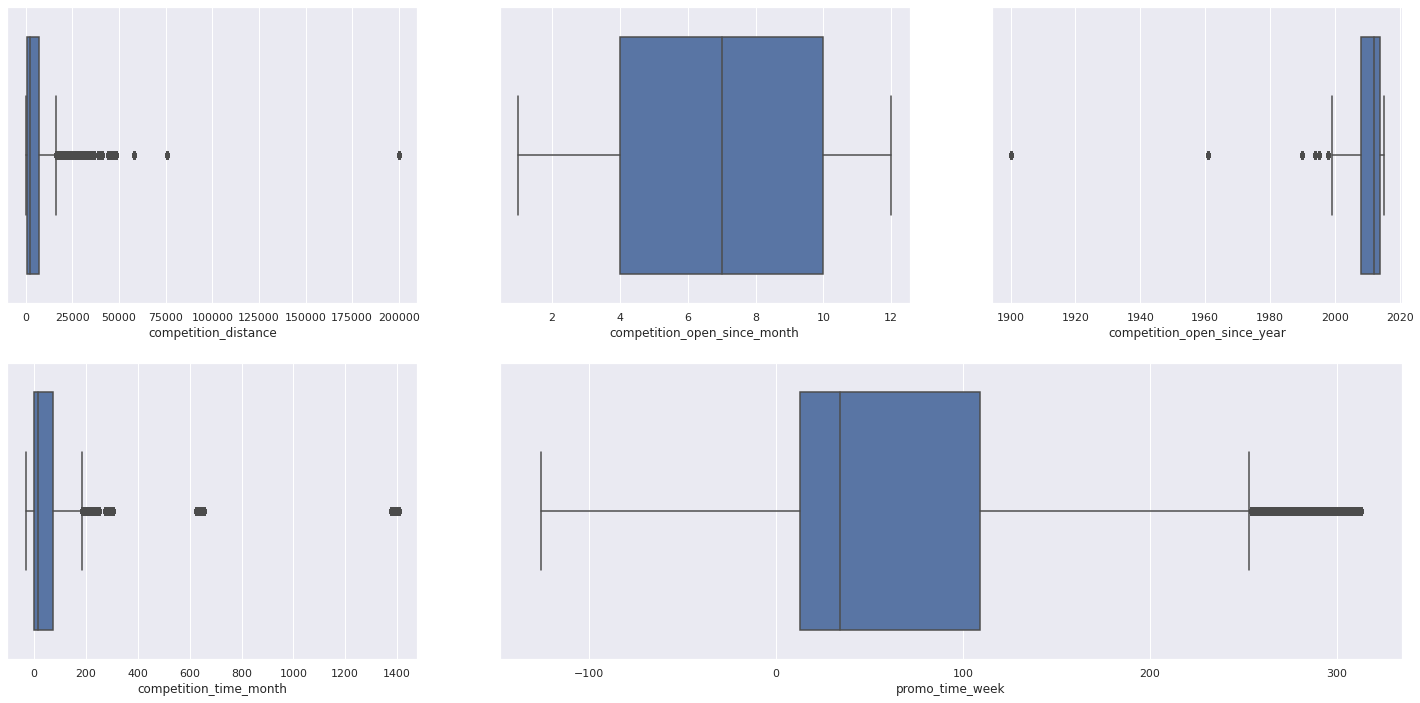

In [55]:
grid = GridSpec(2,3)

subplot(grid[0,0])
sns.boxplot(df4['competition_distance']);# RobustScaler

subplot(grid[0,1])
sns.boxplot(df4['competition_open_since_month']);# This is a irelevant outiers, you will use MinMaxScaller

subplot(grid[0,2])
sns.boxplot(df4['competition_open_since_year']);# RobustScaler

subplot(grid[1,0])
sns.boxplot(df4['competition_time_month']);# RobustScaler

subplot(grid[1,1:])
sns.boxplot(df4['promo_time_week']); # This is a irelevant outiers, you will use MinMaxScaller

#### 4.1.3 Categorical Variable

<p>The Christmas really hight sale, but not highter than public holidays</p>
<p>The Store Type 'd' has most sale than, but we don't have the information what kind is this letters yet</p>
<p>The assortment 'basic' and 'extended' it's closer in count and sales while the extra it's very down sale comparing with others</p>

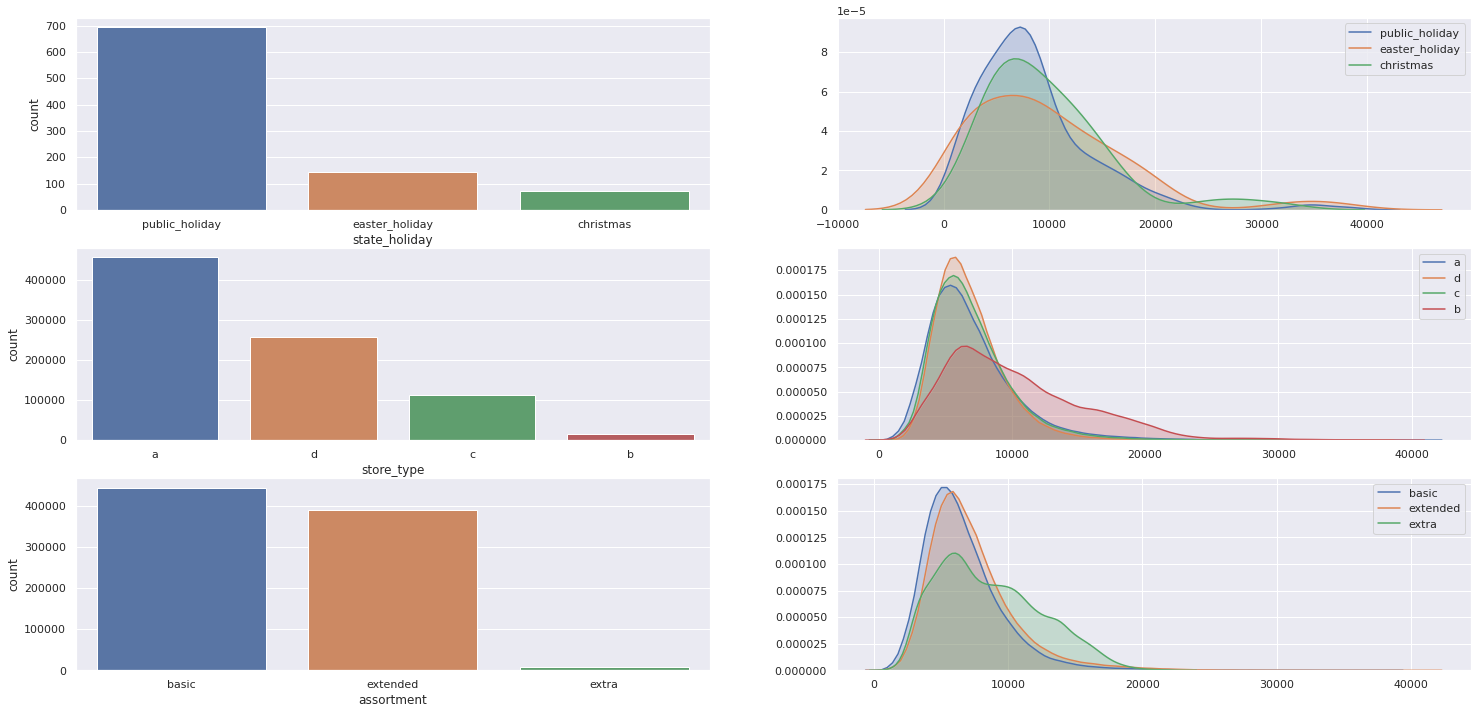

In [56]:
# state holidays - only holidays
plt.subplot(3,2,1)
holidays = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(holidays['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True);

# story_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'], order=['a', 'd', 'c', 'b']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True);

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

### 4.2. Bivariate Analysis

#### 4.2.1 Hypothesis Answers

##### 1. It's supposed to stores that has more assortments more sale
**TRUE** stores with MOST ASSORTMENT sale MORE

As you see, it's TRUE, the EXTRA assortment sale more than extended and basic in mean per store, otherwords, sum sales divided per store numbers has a mean

/home/python/PycharmProjects/Projects/rossmann_sales_forecast/venv_rossmann/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/home/python/PycharmProjects/Projects/rossmann_sales_forecast/venv_rossmann/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


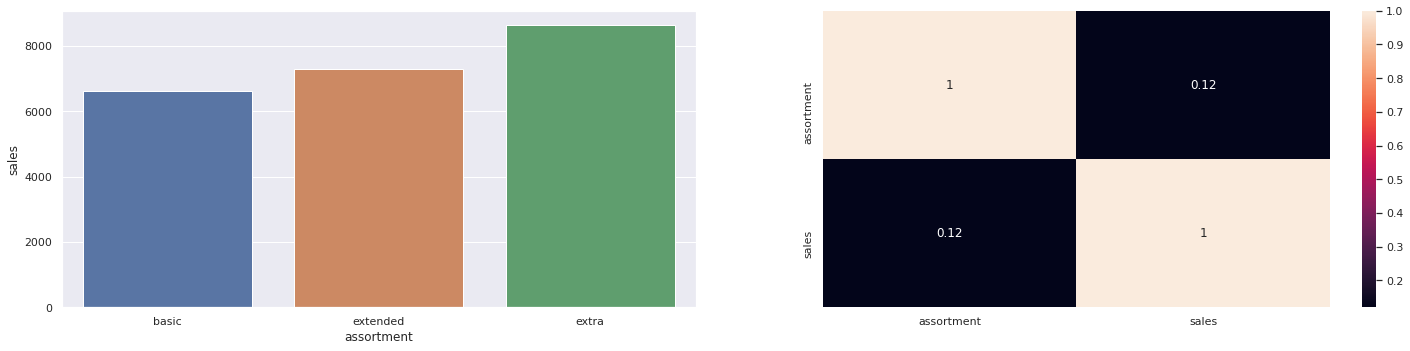

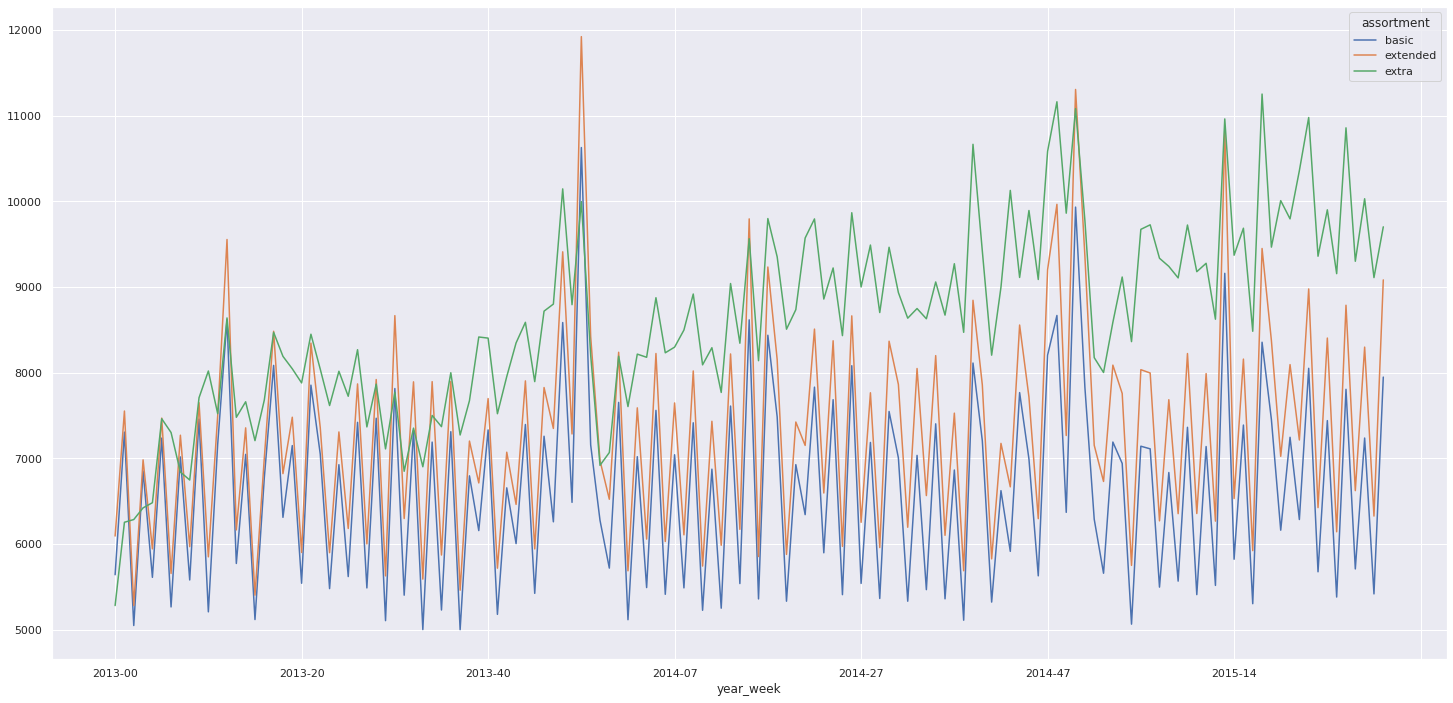

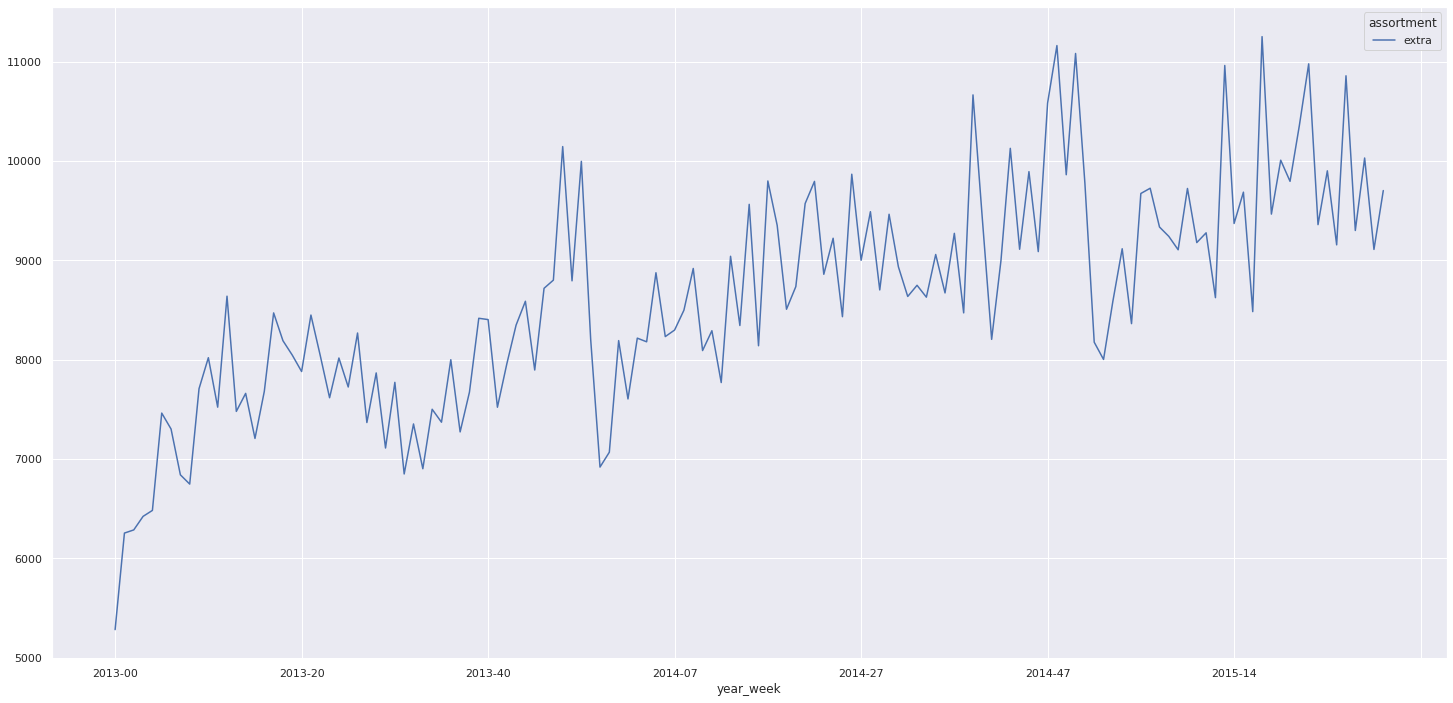

In [57]:
plt.subplot(2,2,3)
aux_ass_mean = df4[['assortment', 'sales']].groupby('assortment', ).mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux_ass_mean);

plt.subplot(2,2,4)
assort_dum = df4[['assortment', 'sales']].copy()
assort_dum['assortment'] = assort_dum['assortment'].map({'basic':0,'extended':1,'extra':2})
sns.heatmap(assort_dum.corr(method='pearson'), annot=True);

aux_mean_week = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()
aux_mean_week.pivot(index='year_week', columns='assortment', values='sales').plot();

aux_m_w_extra = aux_mean_week[aux_mean_week['assortment'] == 'extra'].groupby(['year_week', 'assortment']).mean().reset_index()
aux_m_w_extra.pivot(index='year_week', columns='assortment', values='sales').plot();

##### 2. It's supposed to how more distance from competitors, more sale
**FALSE** stores with MORE DISTANCE from competitors, don't have importance, in FACT neither MORE or LESS

In [58]:
# The real max() at the column competition_distance is 75860, otherwise the value that
# I can do bins is ultil round max() arange( 0,76000,1000 ) start zero until 80k step by 1k
# in this case get the mean it's better, upper than 5 it's better 
# where there are more counts ultil 23k

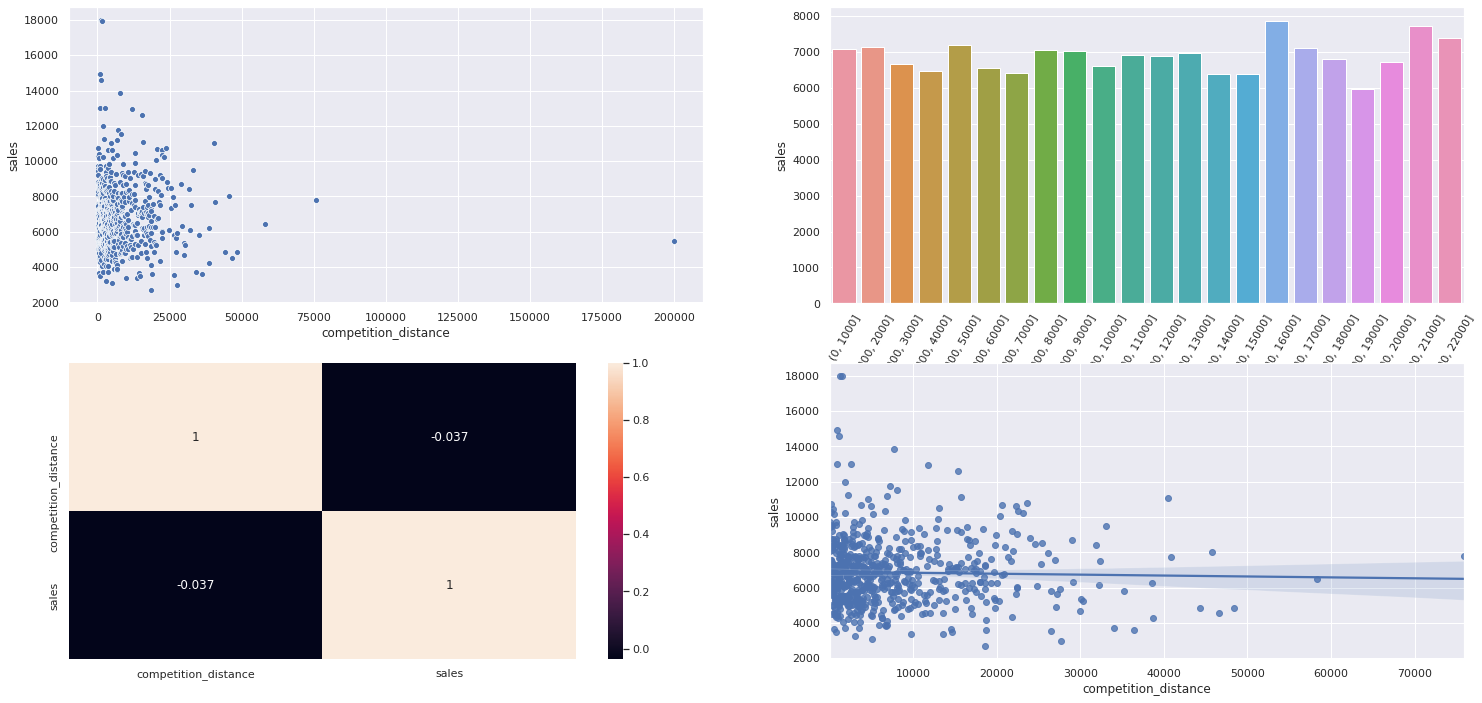

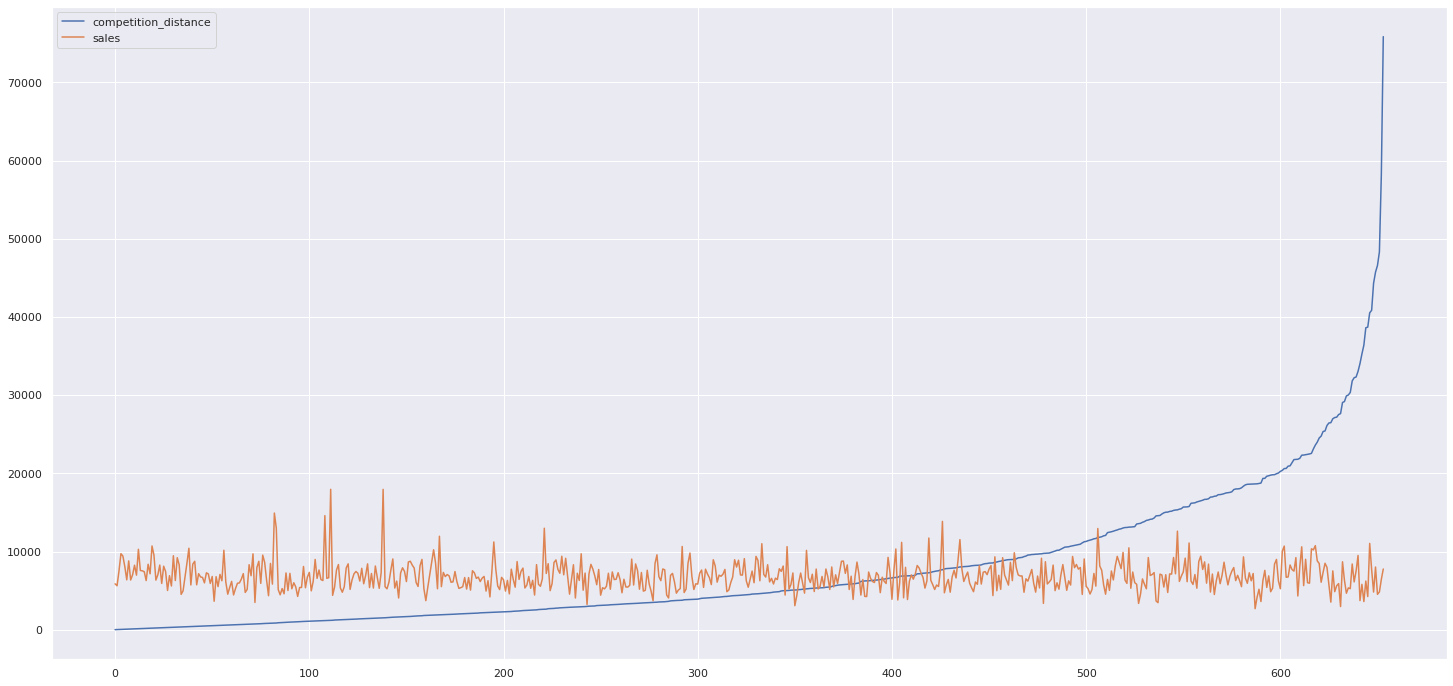

In [59]:
plt.subplot(2,2,1)
com_dist_mean = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=com_dist_mean);

plt.subplot(2,2,2)
bins = list(np.arange(0, 23000, 1000))

com_dist_mean['competition_distance_binned'] = pd.cut(com_dist_mean['competition_distance'], bins=bins)
com_dist_mean_bin = com_dist_mean[['competition_distance_binned', 'sales']].groupby(
    'competition_distance_binned').mean().reset_index();
sns.barplot(x='competition_distance_binned', y='sales', data=com_dist_mean_bin);
plt.xticks(rotation=60)

plt.subplot(2,2,3)
sns.heatmap(com_dist_mean.corr(method='pearson'), annot=True);

plt.subplot(2,2,4)
sns.regplot(x='competition_distance', y='sales', 
            data=com_dist_mean[com_dist_mean['competition_distance'] < 78000]);


com_dist_mean[com_dist_mean['competition_distance'] < 80000].plot();
# as you see it's False, because the aren't a comportament like a linear growth

#####  3. It's supposed to how much more long time competitors, more sale
**FALSE AND TRUE** - If BELLOW then 10 years SALE LESS, and, ABOVE then 10 years, SALE MORE.

###### ISSUES

There are negative months, it's wrong, because it's impossible negative month

In [60]:
print(df4['competition_time_month'].describe())

count    844338.000000
mean         41.679672
std          66.814412
min         -32.000000
25%           0.000000
50%          16.000000
75%          74.000000
max        1407.000000
Name: competition_time_month, dtype: float64


There are so many dates before the Rossmann foundation 1972, this way, something is wrong in this date, link <a href="https://www.rossmann.de/unternehmen/ueber-uns.html">Rossmann History</a>

In [61]:
df1[df1['competition_open_since_year'] < 1972].groupby('competition_open_since_year').count()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
competition_open_since_year,,,,,,,,,,,,,,,,,,,
1900,758,758,758,758,758,758,758,758,758,758,758,758,758,758,758,758,758,758,758
1961,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942,942


###### Body

<p>I filtered to uper from 1972 because the first store was open in 1972, and the dataset has 1900, it's wrong.</p>
<p>I filtered to uper from 516 time month, because the 516 months corresponding uper 1972 when the company founded</p>

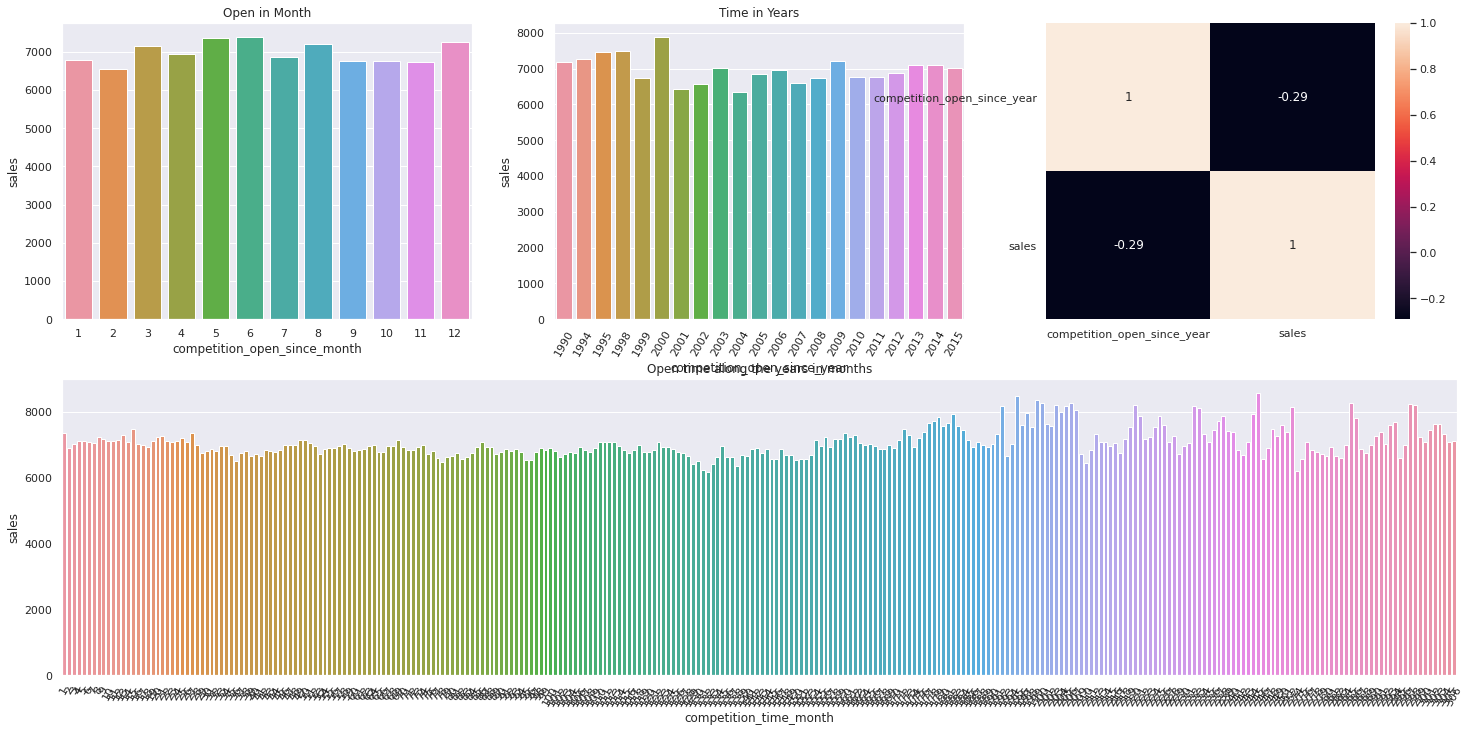

In [62]:
grid = GridSpec(2,3)

plt.subplot(grid[0,0])
plt.title('Open in Month')
aux_month = df4[['competition_open_since_month', 'sales']].groupby('competition_open_since_month').mean().reset_index()
sns.barplot(x='competition_open_since_month', y='sales', data=aux_month);

plt.subplot(grid[0,1])
plt.title('Time in Years')
aux_year_1972 = df4[['competition_open_since_year', 'sales']][df4['competition_open_since_year'] >= 1972]
aux_year_1972 = aux_year_1972[['competition_open_since_year', 'sales']].groupby('competition_open_since_year').mean().reset_index()
sns.barplot(x='competition_open_since_year', y='sales', data=aux_year_1972);
plt.xticks(rotation=60);

plt.subplot(grid[0,2])
sns.heatmap(aux_year_1972.corr(method='pearson'), annot=True)

plt.subplot(grid[1,:])
plt.title('Open time along the years in months')
aux_time_month = df4[['competition_time_month', 'sales']][(df4['competition_time_month'] > 0) & (df4['competition_time_month'] <= 516)]
aux_time_month = aux_time_month.groupby('competition_time_month').mean().reset_index()
sns.barplot(x='competition_time_month', y='sales', data=aux_time_month);
plt.xticks(rotation=60);

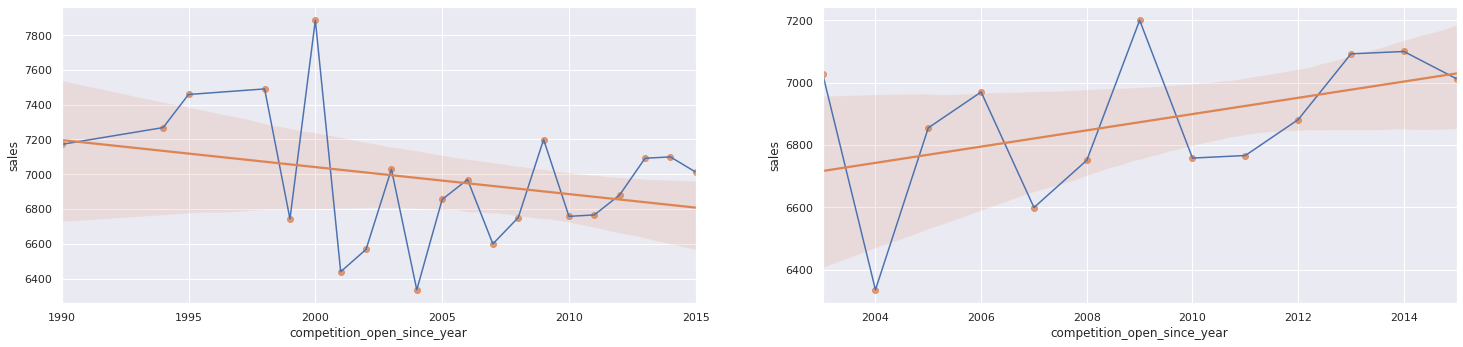

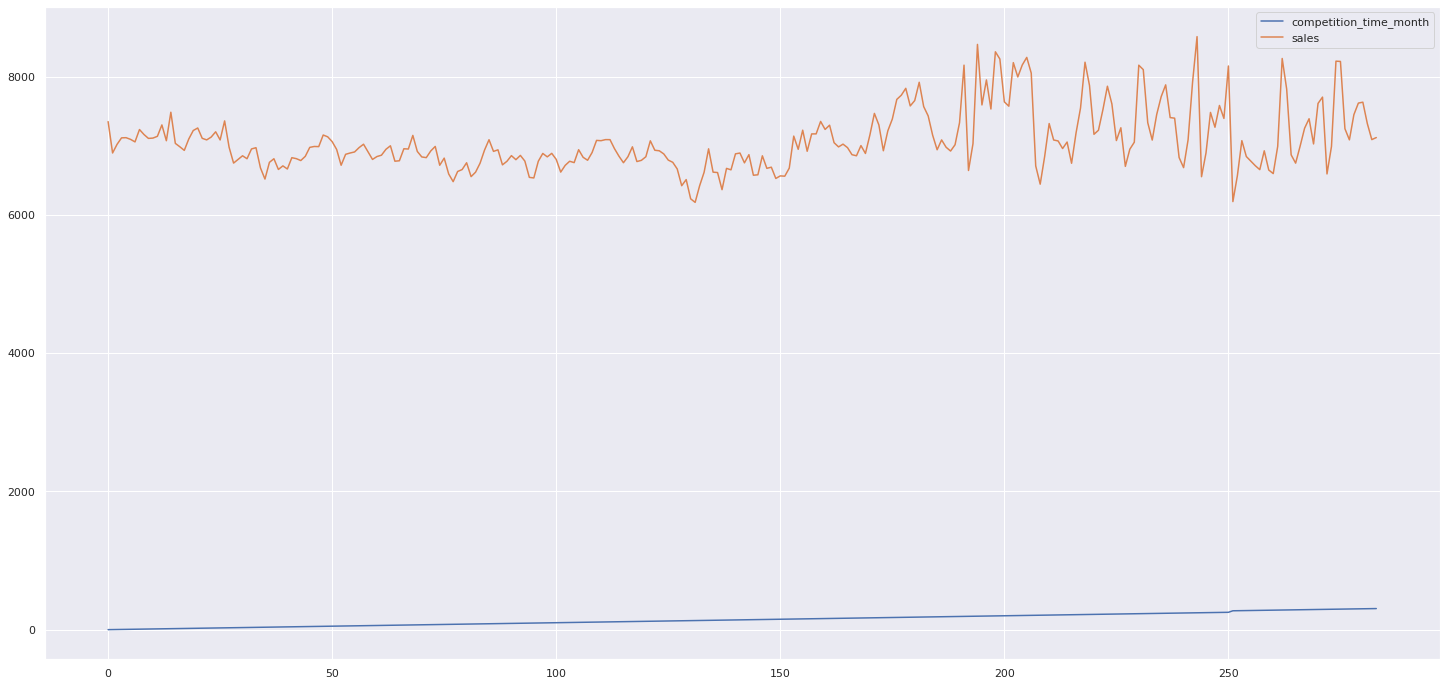

In [63]:
grid = GridSpec(2,2)

plt.subplot(grid[0,0])
sns.lineplot(x='competition_open_since_year', y='sales', data=aux_year_1972);
sns.regplot(x='competition_open_since_year', y='sales', data=aux_year_1972);

plt.subplot(grid[0,1])
# Competition filtered by [competition_open_since_year] upper than 2003
aux_year_2003 = aux_year_1972[['competition_open_since_year', 'sales']][aux_year_1972['competition_open_since_year'] >= 2003]
sns.lineplot(x='competition_open_since_year', y='sales', data=aux_year_2003);
sns.regplot(x='competition_open_since_year', y='sales', data=aux_year_2003);

aux_time_month.plot();


#####  4. It's supposed to how much longer time promotion active, more sale
**TRUE** It's sale more if extended promotion, it's a little growth, but it's true

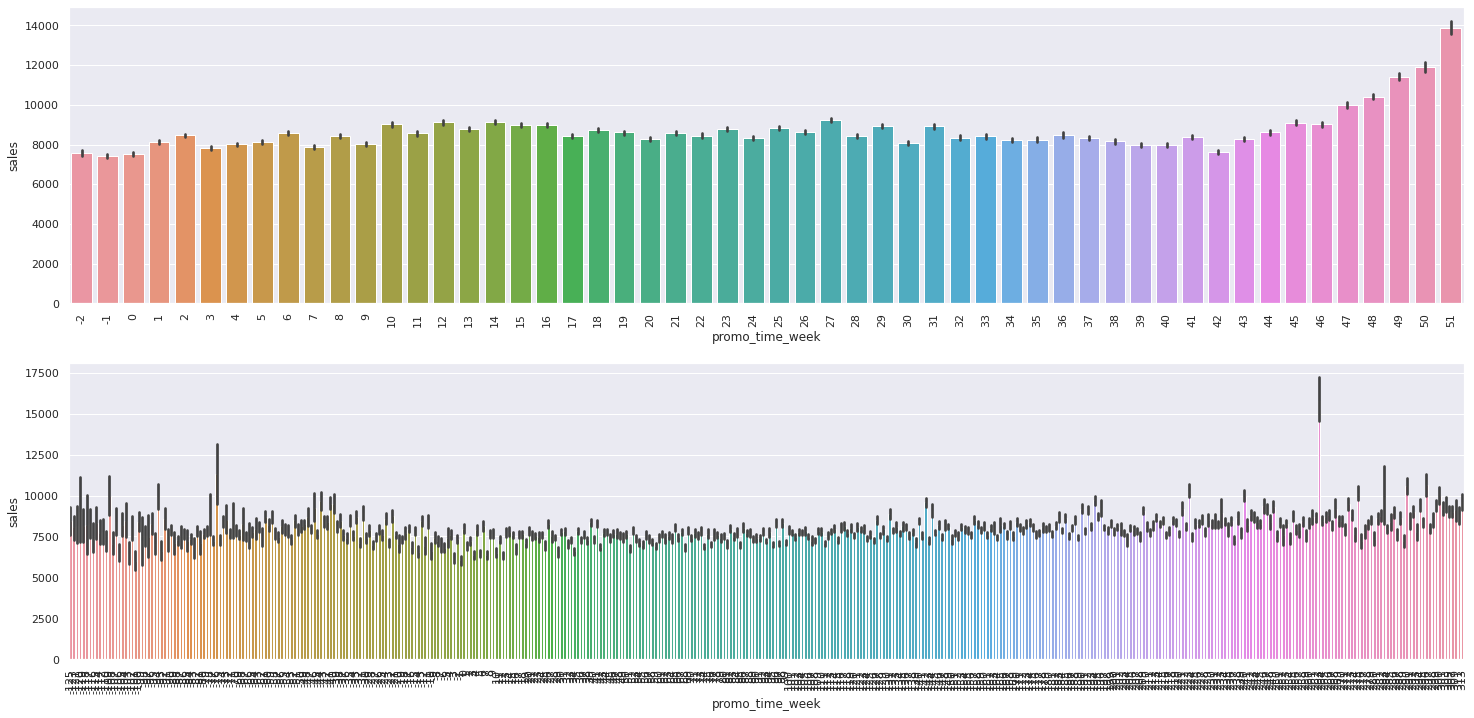

In [64]:
# Normal Promo
plt.subplot(2,1,1)
sns.barplot(x='promo_time_week', y='sales', data=df4[(df4['promo2'] == 0) & (df4['promo'] == 1)]);
plt.xticks(rotation=90);

# Extended Promo
plt.subplot(2,1,2)
sns.barplot(x='promo_time_week', y='sales', data=df4[(df4['promo2'] == 1) & (df4['promo'] == 1)]);
plt.xticks(rotation=90);

In [65]:
# Promo extended
regular_promo = df4[['promo_time_week', 'sales']][(df4['promo'] == 1) & (df4['promo2'] == 0)]
regular_promo_group = regular_promo.groupby('promo_time_week').mean().reset_index()

# Normal Promo
extended_promo = df4[['promo_time_week', 'sales']][(df4['promo'] == 1) & (df4['promo2'] == 1)]
extended_promo_group = extended_promo.groupby('promo_time_week').mean().reset_index()

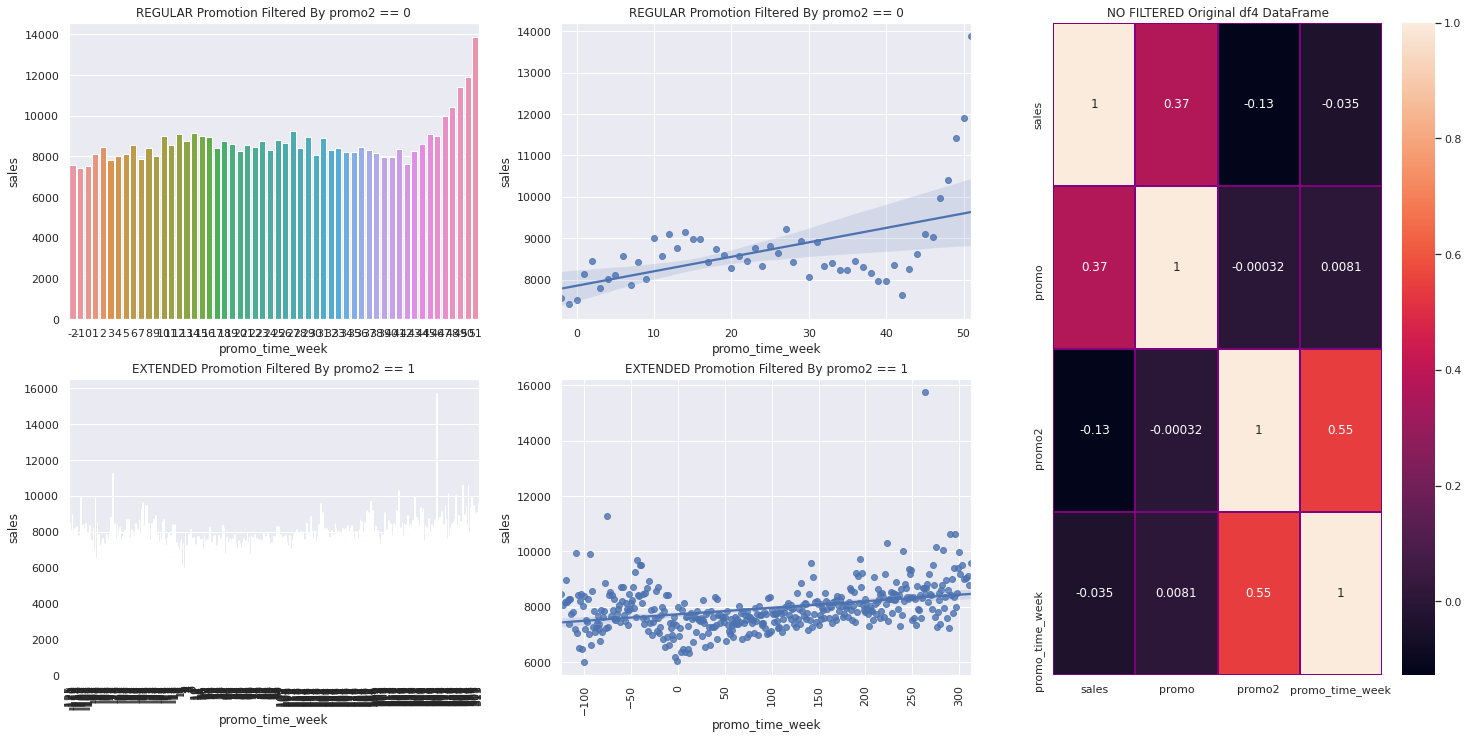

In [66]:
grid = GridSpec(2,3)

# Regular Promotion
plt.subplot(grid[0,0], title='REGULAR Promotion Filtered By promo2 == 0')
sns.barplot(x='promo_time_week', y='sales', data=regular_promo_group);

plt.subplot(grid[0,1], title='REGULAR Promotion Filtered By promo2 == 0')
sns.regplot(x='promo_time_week', y='sales', data=regular_promo_group);

# Extended Promotion
plt.subplot(grid[1,0], title='EXTENDED Promotion Filtered By promo2 == 1')
sns.barplot(x='promo_time_week', y='sales', data=extended_promo_group, color='blue');
plt.xticks(rotation=90);

plt.subplot(grid[1,1], title='EXTENDED Promotion Filtered By promo2 == 1')
sns.regplot(x='promo_time_week', y='sales', data=extended_promo_group);
plt.xticks(rotation=90);

plt.subplot(grid[:,2], title='NO FILTERED Original df4 DataFrame')
sns.heatmap(df4[['sales', 'promo', 'promo2', 'promo_time_week']].corr(), 
            annot=True, linewidths=1, linecolor='purple');

#####  <s>5. It's supposed to how much days in promotion, more sale</s>
**LEFT TO SECOND CYCLE**

#####  6. It's supposed to how much consecutives promotion, more sale
**FALSE** - REGULAR promotion sale MORE, when extended promotion, sale LESS.

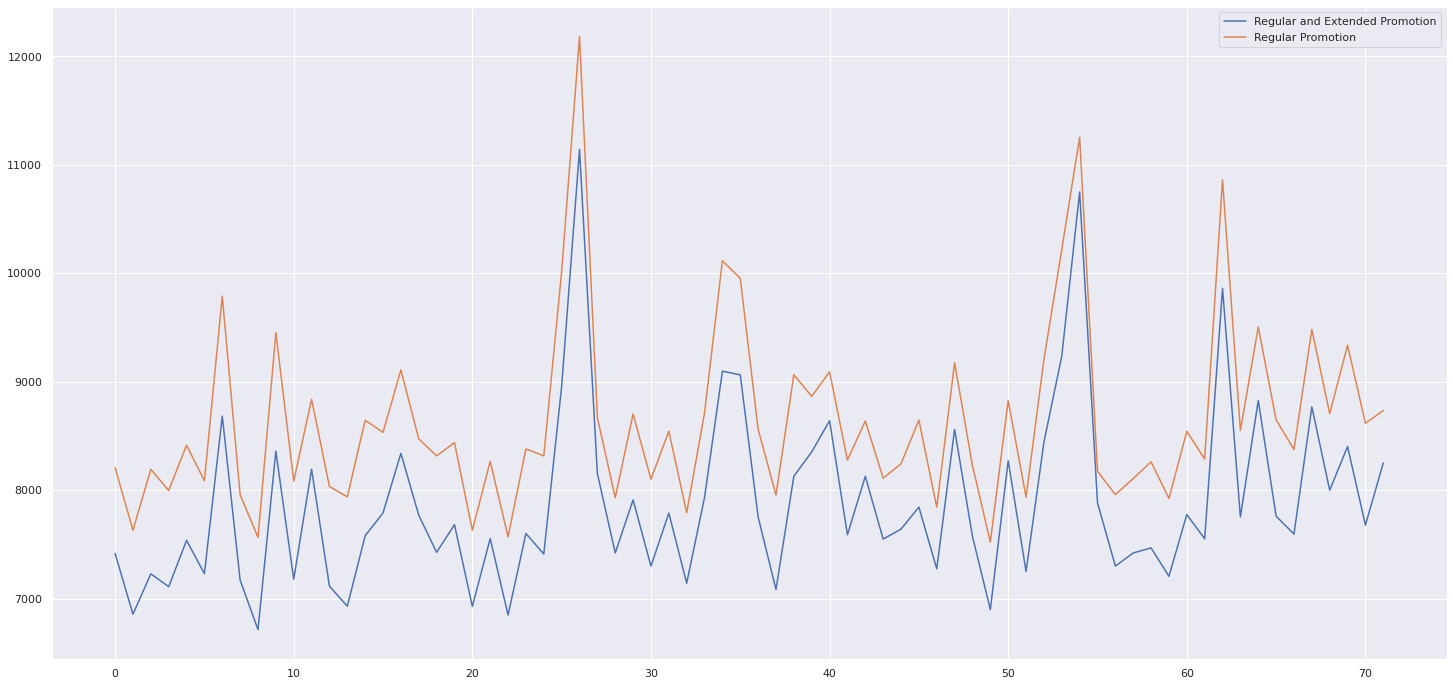

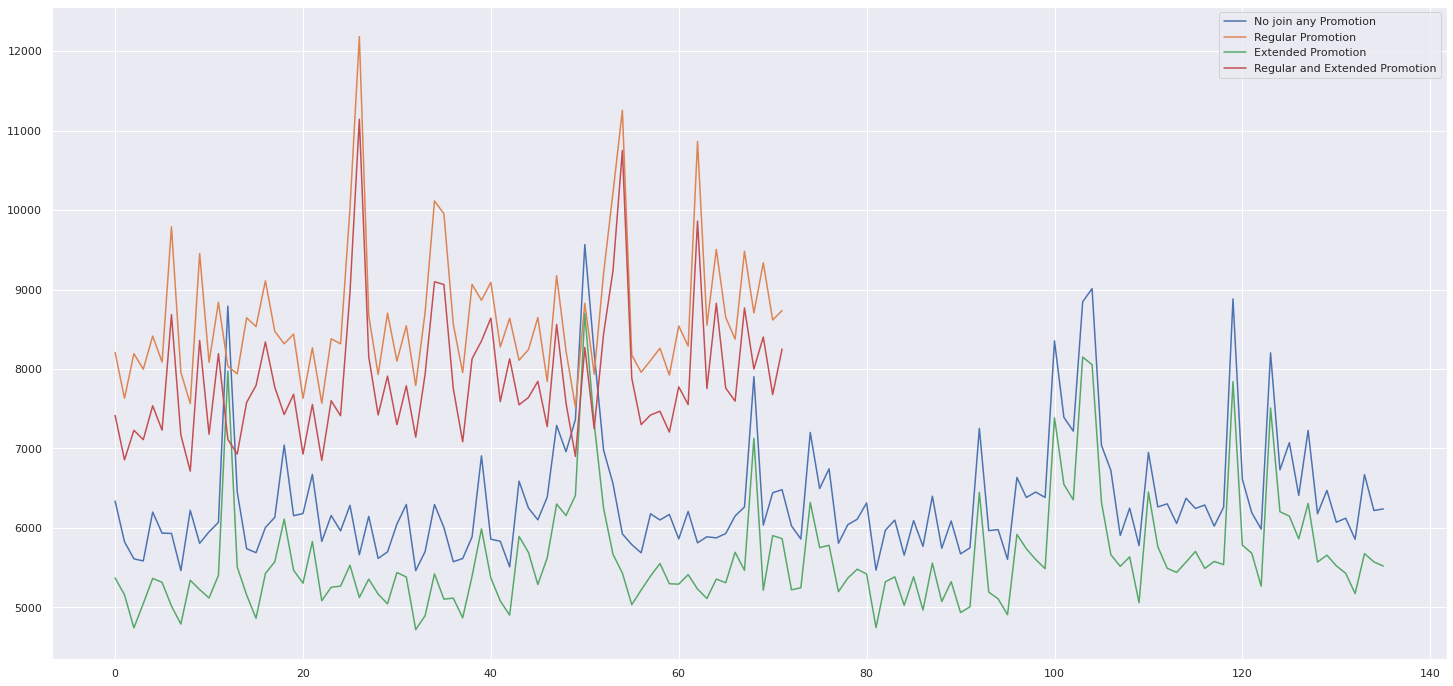

In [67]:

regular_extended_promo = df4[['year_week', 'sales']][(df4['promo'] == 1) & (
    df4['promo2'] == 1)].groupby('year_week').mean().reset_index()
ax = regular_extended_promo.plot();
regular_promo = df4[['year_week', 'sales']][(df4['promo'] == 1) & (
    df4['promo2'] == 0)].groupby('year_week').mean().reset_index()
regular_promo.plot(ax=ax);
plt.legend(labels=['Regular and Extended Promotion', 'Regular Promotion']);


no_promo = df4[['year_week', 'sales']][(df4['promo'] == 0) & (
    df4['promo2'] == 0)].groupby('year_week').mean().reset_index()
ax = no_promo.plot();
regular_promo = df4[['year_week', 'sales']][(df4['promo'] == 1) & (
    df4['promo2'] == 0)].groupby('year_week').mean().reset_index()
regular_promo.plot(ax=ax);
extended_promo = df4[['year_week', 'sales']][(df4['promo'] == 0) & (
    df4['promo2'] == 1)].groupby('year_week').mean().reset_index()
extended_promo.plot(ax=ax);
regular_extended_promo = df4[['year_week', 'sales']][(df4['promo'] == 1) & (
    df4['promo2'] == 1)].groupby('year_week').mean().reset_index()
regular_extended_promo.plot(ax=ax);
plt.legend(labels=['No join any Promotion', 'Regular Promotion', 
                   'Extended Promotion', 'Regular and Extended Promotion']);

#####  7. It's supposed to the store open in the christmas holiday sale more
**TRUE** Open in CHRISTMAS sale MORE than regular days and public holiday, but no more than easter 

<p>In this case we have the problem, there are day 26 and 25 like a christmas, it can't do</p>
<p>But both sale more than regular days</p>
<p></p>

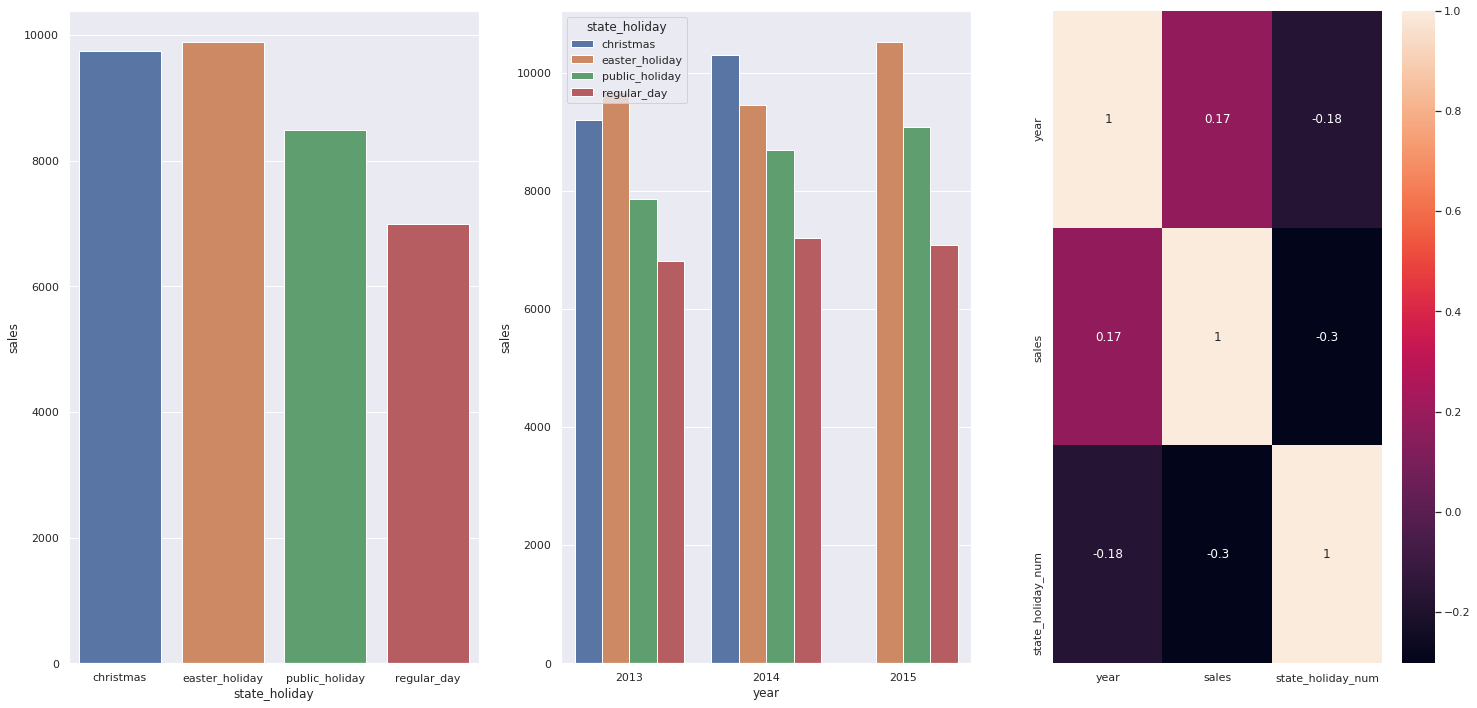

In [68]:
grid = GridSpec(1,3)

plt.subplot(grid[0,0])
holiday_sales = df4[['state_holiday', 'sales']].groupby('state_holiday', sort=True).mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=holiday_sales);

plt.subplot(grid[0,1])
state_holiday = df4[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=state_holiday);
# In this chart there aren't 2015 christmas, but, as you see probably would sale more than others

plt.subplot(grid[0,2])
maps = {'easter_holiday':0,'public_holiday':1, 'regular_day':2, 'christmas':3}
state_holiday['state_holiday_num'] = state_holiday['state_holiday'].map(maps)
sns.heatmap(state_holiday.corr(method='pearson'), annot=True);

#####  8. It's supposed to sale more along the years
**TRUE** Along the years sale more

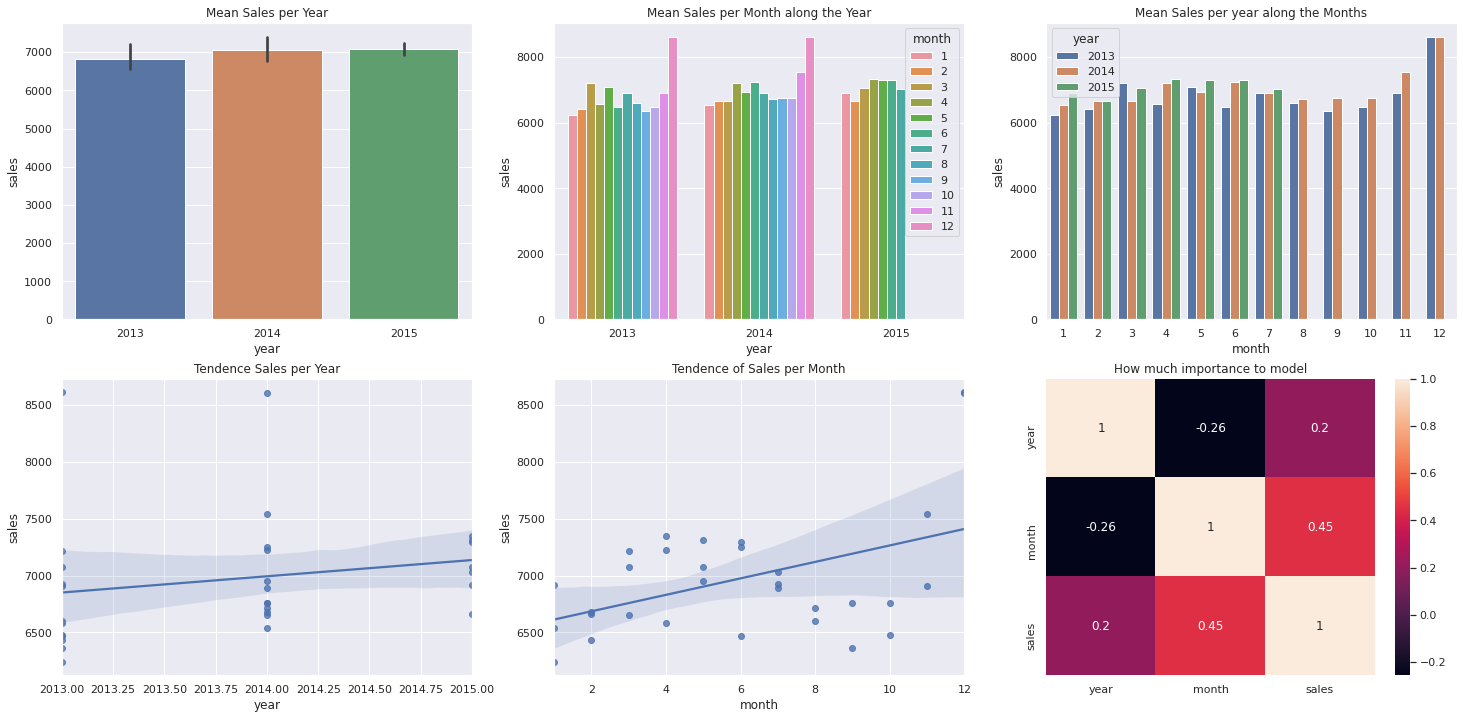

In [69]:
year_gp = df4[['month', 'year', 'sales']].groupby(['year', 'month']).mean().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0], title='Mean Sales per Year')
sns.barplot(x='year', y='sales', data=year_gp);

plt.subplot(grid[0,1], title='Mean Sales per Month along the Year')
sns.barplot(x='year', y='sales', hue='month', data=year_gp);

plt.subplot(grid[0,2], title='Mean Sales per year along the Months')
sns.barplot(x='month', y='sales', hue='year', data=year_gp);

plt.subplot(grid[1,0], title='Tendence Sales per Year')
sns.regplot(x='year', y='sales', data=year_gp);

plt.subplot(grid[1,1], title='Tendence of Sales per Month')
sns.regplot(x='month', y='sales', data=year_gp);

plt.subplot(grid[1,2], title='How much importance to model')
sns.heatmap(year_gp.corr(method='pearson'), annot=True);

#####  9. It's supposed to sale more in the second semester
**TRUE** SECOND Semester SALE MORE, probably because the christmas sales.

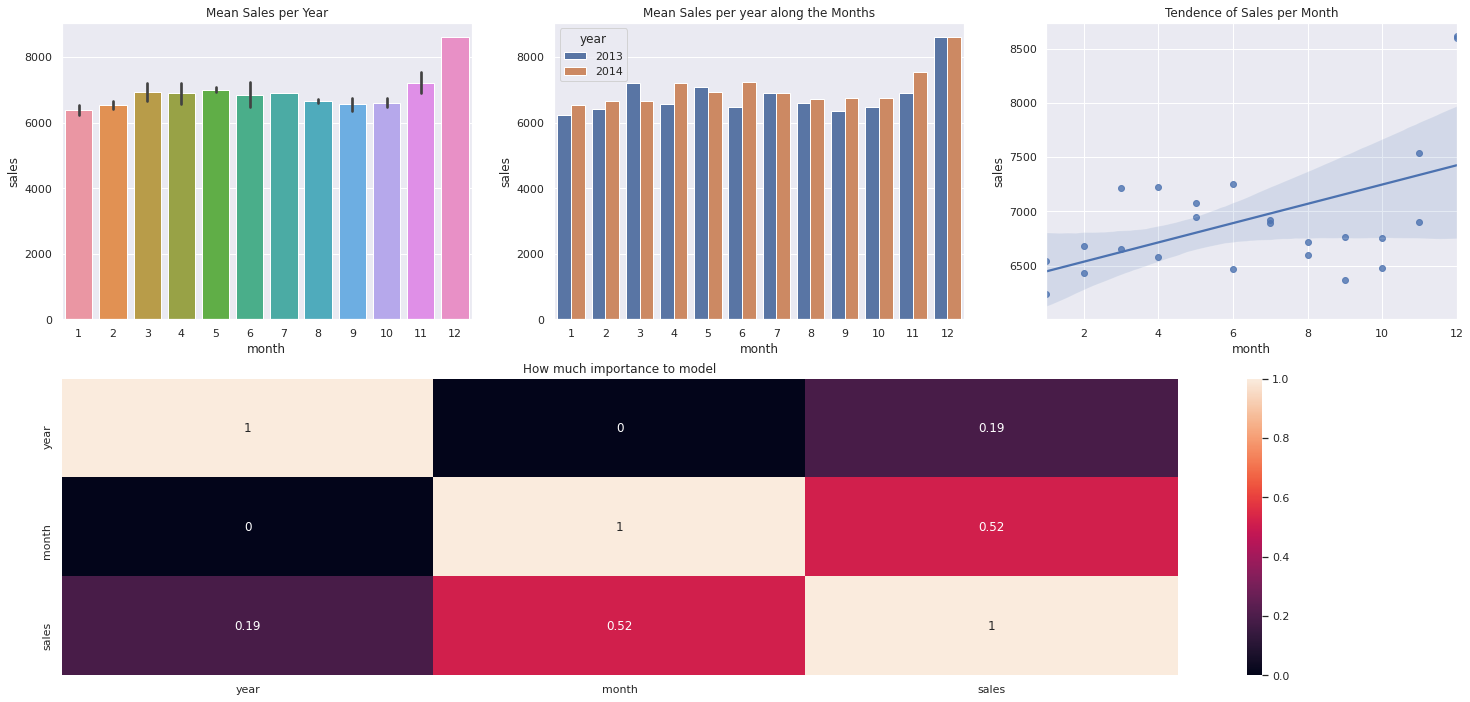

In [70]:
year_gp = df4[['month', 'year', 'sales']][df4['year'] < 2015].groupby(['year', 'month']).mean().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0], title='Mean Sales per Year')
sns.barplot(x='month', y='sales', data=year_gp);

plt.subplot(grid[0,1], title='Mean Sales per year along the Months')
sns.barplot(x='month', y='sales', hue='year', data=year_gp);

plt.subplot(grid[0,2], title='Tendence of Sales per Month')
sns.regplot(x='month', y='sales', data=year_gp);

plt.subplot(grid[1,:], title='How much importance to model')
sns.heatmap(year_gp.corr(method='pearson'), annot=True);

As you see above it's very dificulty understand data, because it's closer, but bellow you can see the mean divided in two semesters, and mean show that the second sale more, but there aren't data on second semester of 2015 and probably saling more than 2013 and 2014, you can see that december is the responsible to second semester saler than first.

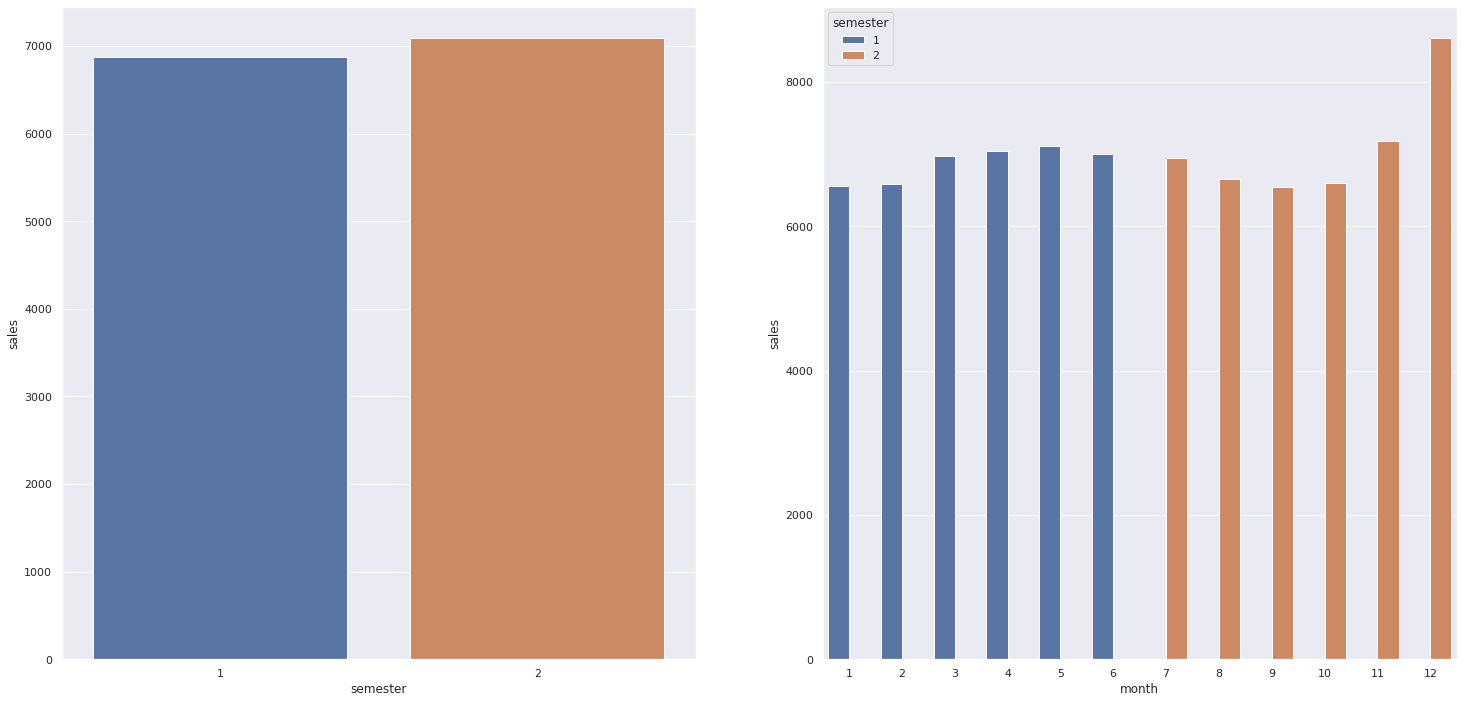

In [71]:
# Slicing in two semesters
first_semester = df4[df4['month'] <= 6]
second_semester = df4[df4['month'] > 6]
first_semester = first_semester[['month', 'sales']].groupby('month').mean().reset_index()
second_semester = second_semester[['month', 'sales']].groupby('month').mean().reset_index()
first_semester['semester'] = 1
second_semester['semester'] = 2

#New dataframe to plot viewer
semester = pd.concat([first_semester, second_semester], axis=0)
semester_gp = semester.groupby('semester').mean().reset_index()

#plotting bar
plt.subplot(1,2,1)
sns.barplot(x='semester', y='sales', data=semester_gp);

plt.subplot(1,2,2)
sns.barplot(x='month', y='sales', hue='semester', data=semester);

#####  10. It's supposed to sale more after day 10 from each month
**FALSE** - After day 10 sales less

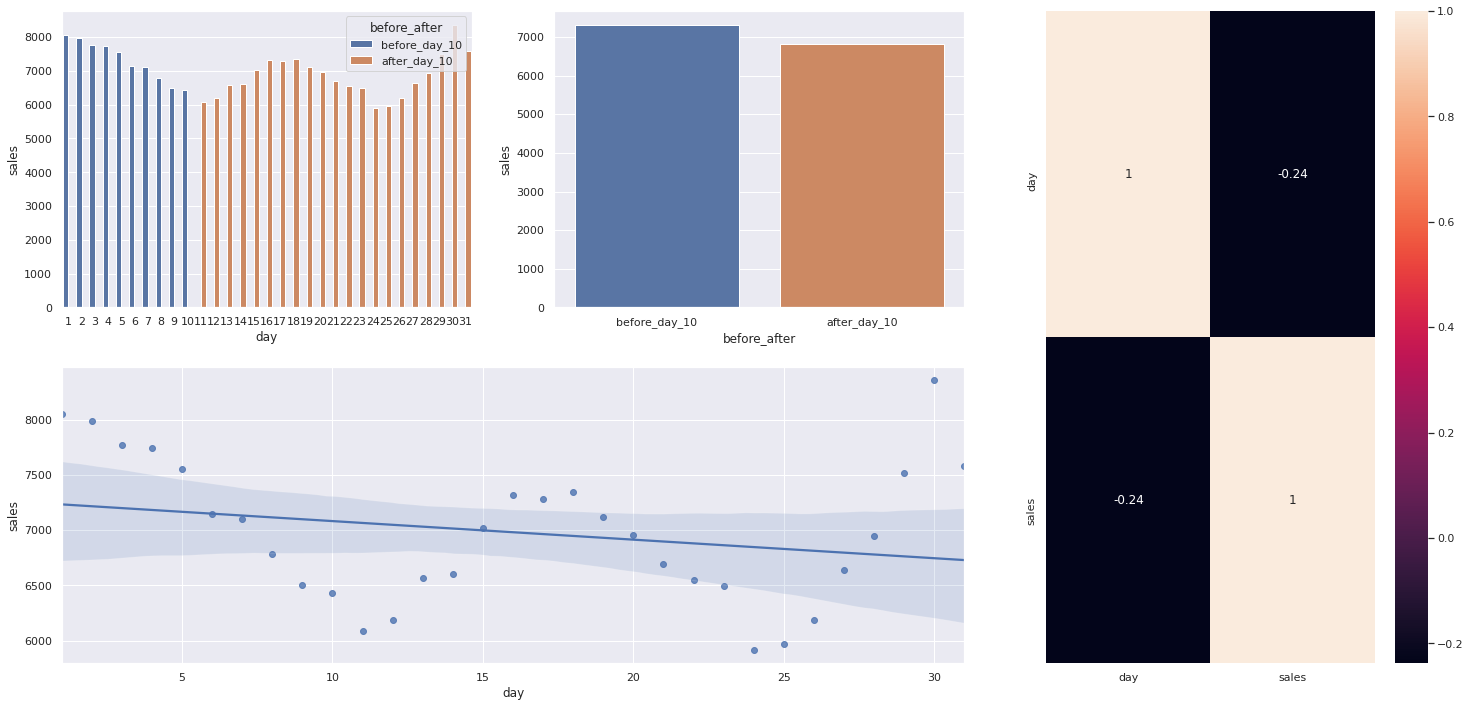

In [72]:
# Filtering and create new columns to store the cut data before and after day 10
day_sales = df4[['day', 'sales']].groupby('day').mean().reset_index()
day_sales['before_after'] = day_sales['day'].apply( lambda x: 'before_day_10' if x <= 10 else 'after_day_10' )
day_sales_bef_aft = day_sales.groupby('before_after').mean().reset_index()

# grid template to set the local where plotting
grid = GridSpec(2,3)

plt.subplot(grid[0,0])
sns.barplot(x='day', y='sales', hue='before_after', data=day_sales);

plt.subplot(grid[0,1])
sns.barplot(x='before_after', y='sales', data=day_sales_bef_aft, order=['before_day_10', 'after_day_10'])

plt.subplot(grid[1,0:2])
sns.regplot(x='day', y='sales', data=day_sales);

plt.subplot(grid[:,2])
sns.heatmap(day_sales.corr(method='pearson'), annot=True);

#####  11. It's supposed to on the weekend you will sales less
**TRUE** - On the WEEKEND sale LESS, but on the sunday is second better day with more sale

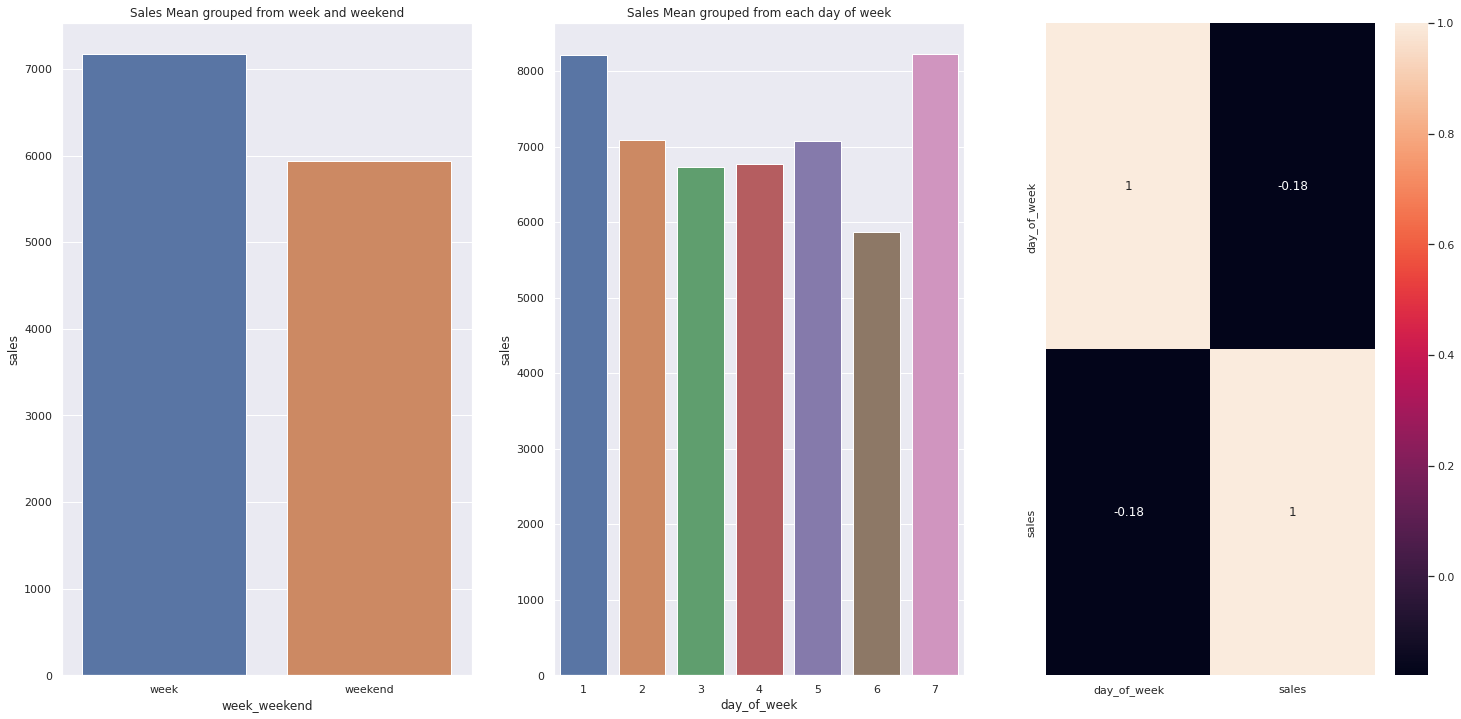

In [73]:
df_week_end = df4[['day_of_week', 'sales']].copy()
df_week_end['week_weekend'] = df_week_end['day_of_week'].apply( lambda x: 'week' if x <=5 else 'weekend' )
df_week_gp = df_week_end.groupby('week_weekend').mean().reset_index()

grid = GridSpec(1,3)

plt.subplot(grid[0,0], title='Sales Mean grouped from week and weekend')
sns.barplot(x='week_weekend', y='sales', data=df_week_gp);

plt.subplot(grid[0,1], title='Sales Mean grouped from each day of week')
day_week_sales = df4[['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()
sns.barplot(x='day_of_week', y='sales', data=day_week_sales);

plt.subplot(grid[0,2])
sns.heatmap(df4[['day_of_week', 'sales']].corr(method='pearson'), annot=True);

#####  12. It's supposed to holidays school sale less
**FALSE** - On the SCHOOL holidays sale little MORE, except on DECEMBER sale LESS

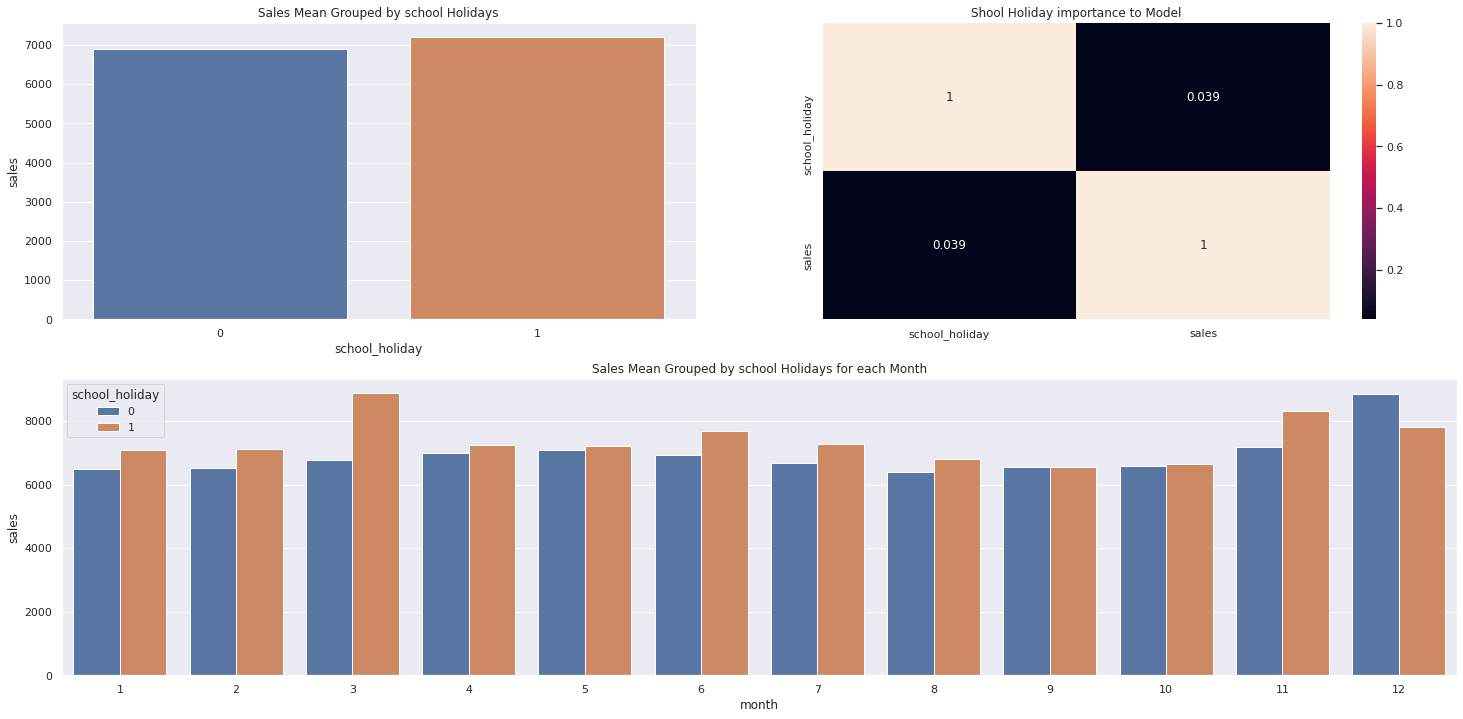

In [74]:
school_holiday = df4[['month', 'school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

grid = GridSpec(2,2)

plt.subplot(grid[0,0], title='Sales Mean Grouped by school Holidays')
sns.barplot(x='school_holiday', y='sales', data=school_holiday);

plt.subplot(grid[0,1], title='Shool Holiday importance to Model')
sns.heatmap(df4[['school_holiday', 'sales']].corr(method='pearson'), annot=True);

plt.subplot(grid[1,:], title='Sales Mean Grouped by school Holidays for each Month')
school_h_month = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).mean().reset_index()
sns.barplot(x='month', hue='school_holiday', y='sales', data=school_h_month);

####  4.2.2 Hypothesis Review

<table>
    <tr>
        <th>Hypothesis</th>
        <th>Conclusion</th>
        <th>Relevance</th>
        <th>Conclusion Description</th>
    </tr>
    <tr>
        <td>1. It's supposed to stores that has more assortments more sale</td>
        <td>TRUE</td>
        <td>LOW</td>
        <td>Stores with MOST ASSORTMENT sale MORE</td>
    </tr>
    <tr>
        <td>2. It's supposed to how more distance from competitors, more sale</td>
        <td>FALSE</td>
        <td>LOW</td>
        <td>Stores with MORE DISTANCE from competitors, don't have importance, in FACT neither MORE or LESS</td>
    </tr>
    <tr>
        <td>3. It's supposed to how much more long time competitors, more sale</td>
        <td>TRUE AND FALSE</td>
        <td>LOW</td>
        <td>If BELLOW then 10 years SALE LESS, and, ABOVE then 10 years, SALE MORE</td>
    </tr>
    <tr>
        <td>4. It's supposed to how much longer time promotion active, more sale</td>
        <td>TRUE</td>
        <td>LOW</td>
        <td>It's sale more if extended promotion, it's a little growth, but it's true</td>
    </tr>
    <tr>
        <td>6. It's supposed to how much consecutives promotion, more sale</td>
        <td>FALSE</td>
        <td>LOW</td>
        <td>REGULAR promotion sale MORE, when extended promotion, sale LESS</td>
    </tr>
    <tr>
        <td>7. It's supposed to the store open in the christmas holiday sale more</td>
        <td>TRUE</td>
        <td>LOW</td>
        <td>Open in CHRISTMAS sale MORE than regular days and public holiday, but no more than easter</td>
    </tr>
    <tr>
        <td>8. It's supposed to sale more along the years</td>
        <td>TRUE</td>
        <td>AVAREGE</td>
        <td>Along the years sale more</td>
    </tr>
    <tr>
        <td>9. It's supposed to sale more in the second semester</td>
        <td>TRUE</td>
        <td>AVAREGE</td>
        <td>SECOND Semester SALE MORE, probably because the christmas sales</td>
    </tr>
    <tr>
        <td>10. It's supposed to sale more after day 10 from each month</td>
        <td>FALSE</td>
        <td>LOW</td>
        <td>After day 10 sales less</td>
    </tr>
    <tr>
        <td>11. It's supposed to on the weekend you will sales less</td>
        <td>TRUE</td>
        <td>LOW</td>
        <td>On the WEEKEND sale LESS, but on the sunday is second better day with more sale</td>
    </tr>
    <tr>
        <td>12. It's supposed to holidays school sale less</td>
        <td>FALSE</td>
        <td>LOW</td>
        <td>On the SCHOOL holidays sale little MORE, except on DECEMBER sale LESS</td>
    </tr>
</table>

### 4.1. Multivariate Analysis

#### 4.1.1. Numerical Atributes

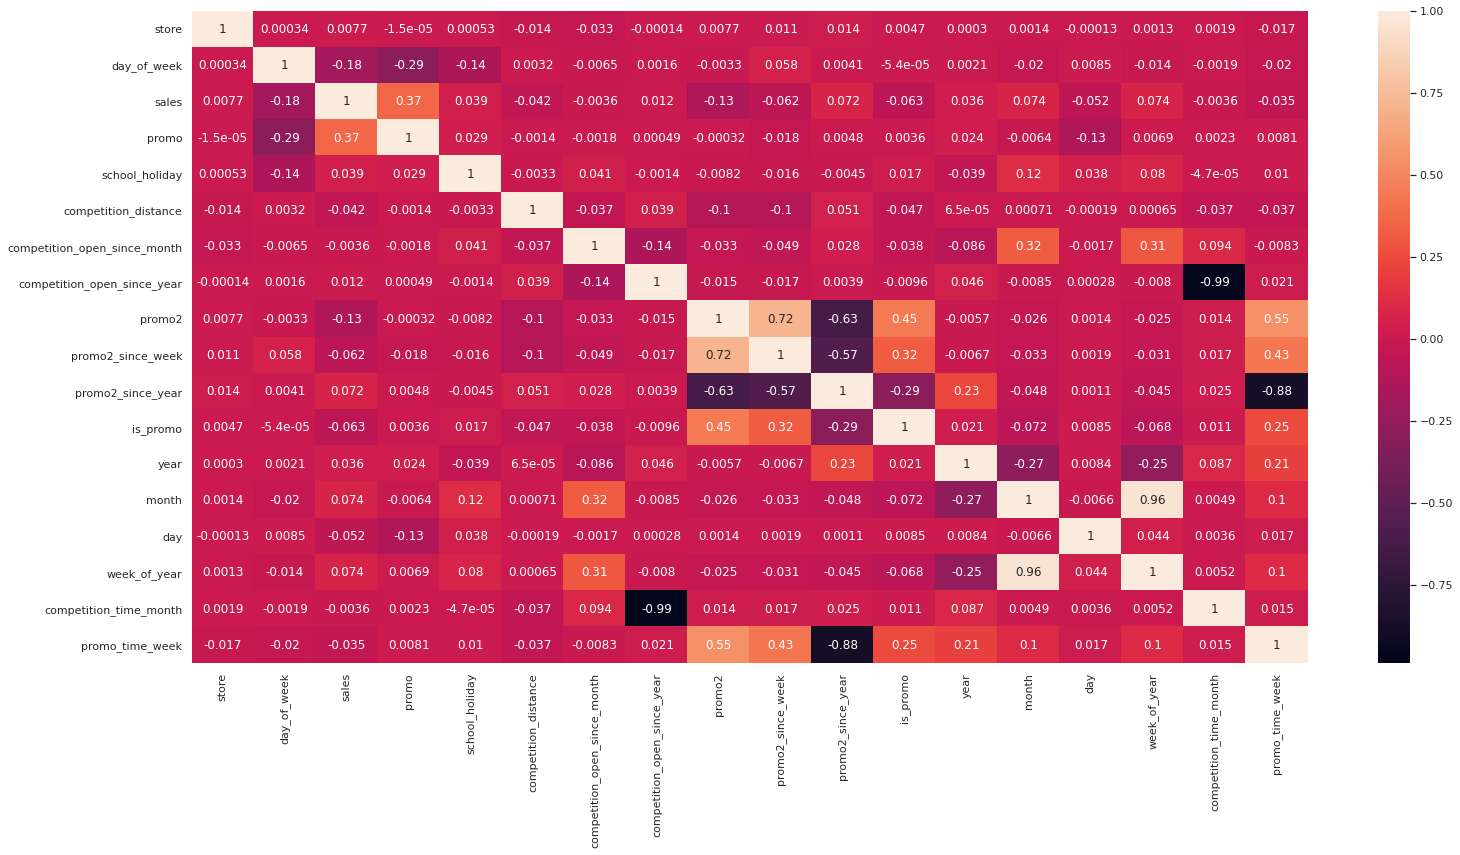

In [75]:
# Slicing and filter for just numbers and date data types
num_attributes = df4.select_dtypes(exclude='object')

# Plotting heatmap
sns.heatmap(num_attributes.corr(method='pearson'), annot=True);

#### 4.1.2. Categorical Atributes

In [76]:
# Slicing and filter for just objects data types
cat_attributes = df4.select_dtypes(include='object')

In [77]:
# For to get name of coluns and calculate cramer_v function 
list_cat = {}
rown = []
for col in cat_attributes.columns:
    for row in cat_attributes.columns:
        rown.append(cramer_v(cat_attributes[col], cat_attributes[row]))
        
    list_cat[col] = rown
    rown = []
    
# take the output from loop and convert to DataFrame
df_cat = pd.DataFrame(list_cat)
df_cat = df_cat.set_index(df_cat.columns)

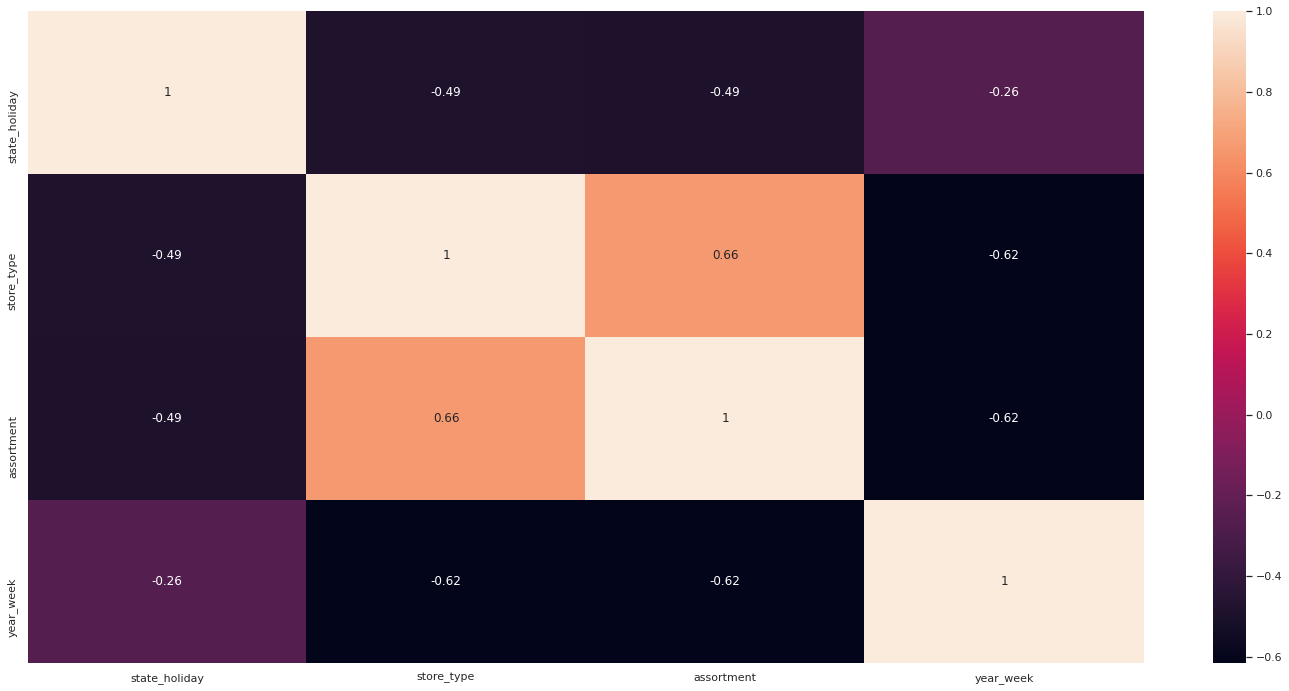

In [78]:
# plotting heatmap to cross correlation
sns.heatmap(df_cat.corr(method='pearson'), annot=True);

## 5.0. Data Preparation 

In [79]:
# Copy data from df4
df5 = df4.copy()

### 5.1. Normalization 

It's not necessary normalization because there aren't normal distribuition

### 5.2. Rescaling

In [80]:
rs = RobustScaler()
mms = MinMaxScaler()

# Very sparsing a far range and far outlier  -> RobustScaler()
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# Very sparsing a far range and far outlier  -> RobustScaler()
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# No relevance outlier  -> MinMaxScaler()
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

In [81]:
# histogram to see the changed data
# df5[['competition_distance','competition_time_month','promo_time_week']].hist(bins=25);

### 5.3. Transformation

#### 5.3.1. Encoding

In [82]:
# state_holiday  -> temporary state, one hot encolding -> get_dummies()
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type     -> it's not correlations              -> LabelEncoder()
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'].values)

# assortment     -> it's ordinal encolding             -> map(basic, extra, extended)
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### 5.3.2. Response Variable Transformation

This action consist in transform target or response variable in a normal distribution with a logarithm function

In [83]:
df5['sales'] = np.log1p(df5['sales'])

#### 5.3.3. Nature Transformation

It's a cycle data, for exemple day of week start on day 1 until day 7 and start again, this is cycle.

Formula to get the sin and cosin is sin( x * ( 2. * pi / n ) ) and cos( x * ( 2. * pi / n ) )

In [84]:
# month          -> It's cycle data        ->
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

# day            -> It's cycle data        ->
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

# week_of_year   -> It's cycle data        ->
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

# day_of_week    -> It's cycle data        ->
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

## 6.0. Feature Selection

In [85]:
# Copy from df5 to df6
df6 = df5.copy()

In [86]:
# All this columns will be dropped, because it's derivate to news columns and representing the same information
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week',]
df6 = df6.drop(cols_drop, axis=1)

# date it's drop too, but not now, because you will use this information yet

### 6.1. Split DataFrame Training and Test

In [87]:
# Getting date point where you will be split
split_date = df6[['date', 'store']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=7*6)

# splitting train and test data to predict 6 weeks
X_train = df6[df6['date'] < split_date]
y_train = X_train['sales']

X_test = df6[df6['date'] >= split_date]
y_test = X_test['sales']

X_train['date'].min(), X_train['date'].max(), X_test['date'].min(), X_test['date'].max()

(Timestamp('2013-01-01 00:00:00'),
 Timestamp('2015-06-18 00:00:00'),
 Timestamp('2015-06-19 00:00:00'),
 Timestamp('2015-07-31 00:00:00'))

### 6.2. Boruta Feature Selection

In [88]:
"""
X_train_n = X_train.drop(['sales', 'date'], axis=1).values
y_train_n = y_train.values.ravel()

rf = RandomForestRegressor( n_jobs=-1 )

# Boruta defining
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n )

cols_selected = boruta.support_.tolist()

# Best Features
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Not Selected
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
"""

"\nX_train_n = X_train.drop(['sales', 'date'], axis=1).values\ny_train_n = y_train.values.ravel()\n\nrf = RandomForestRegressor( n_jobs=-1 )\n\n# Boruta defining\nboruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n )\n\ncols_selected = boruta.support_.tolist()\n\n# Best Features\nX_train_fs = X_train.drop(['date', 'sales'], axis=1)\ncols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()\n\n# Not Selected\ncols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))\n"

### 6.3. Manual Feature Selection

In [89]:
# Merge that features selection from boruta and analyst feeling
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'day_of_week_sin',
    'day_of_week_cos'
]

# Columns not selected from Boruta, rejected
cols_not_selected_boruta = [
    'is_promo',
    'month_sin',
    'school_holiday',
    'state_holiday_christmas',
    'state_holiday_easter_holiday',
    'state_holiday_public_holiday',
    'state_holiday_regular_day',
    'week_of_year_sin',
    'year'
]

## 7.0. Machine Learning Modelling

In [90]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

mdl_result = pd.DataFrame()

### 7.1. Average Model

In [87]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(
    columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# Performance
mdl_result = pd.concat([
    mdl_result,
    ml_error('Average Model', np.expm1(y_test),
                      np.expm1(yhat_baseline))])

mdl_result

,model_name,mae,mape,rmse
0,Average Model,1354.800353,0.455051,1835.135542


### 7.2. Linear Regression Model

In [88]:
# Model
mdl_lr = LinearRegression().fit(x_train, y_train)

# Prediction
yhat_lr = mdl_lr.predict(x_test)

# Performance
mdl_result = pd.concat([
    mdl_result,
    ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
])
mdl_result

,model_name,mae,mape,rmse
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1869.733315,0.295624,2665.954087


### 7.3. Linear Regression Regularized Model

In [89]:
# Model
mdl_lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# Prediction
yhat_lrr = mdl_lrr.predict(x_test)

# Performance
mdl_result = pd.concat([
    mdl_result,
    ml_error('Linear Regression Regularized', np.expm1(y_test),
             np.expm1(yhat_lrr))
])
mdl_result

,model_name,mae,mape,rmse
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1869.733315,0.295624,2665.954087
0,Linear Regression Regularized,1898.241927,0.288271,2764.274231


### 7.4. Random Forest Regressor

In [92]:
# Model
mdl_rf = RandomForestRegressor(n_estimators=100, n_jobs=2,
                               random_state=42).fit(x_train, y_train)

# Prediction
yhat_rf = mdl_rf.predict(x_test)

# Performance
mdl_result = pd.concat([
    mdl_result,
    ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
])
mdl_result

,model_name,mae,mape,rmse
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1869.733315,0.295624,2665.954087
0,Linear Regression Regularized,1898.241927,0.288271,2764.274231
0,Random Forest Regressor,671.101943,0.098751,1001.293067


In [91]:
# pred_true = x_test.copy()
# pred_true['pred'] = yhat_rf.copy()
# pred_true['sales'] = y_test.copy()

In [102]:
#pred_true[['store', 'sales', 'pred']].groupby('store').sum().head()

In [ ]:
#pred_true[['store', 'sales', 'pred']].groupby('store').sum().plot();

In [ ]:
#pred_true[['store', 'sales', 'pred']].groupby('store').mean().plot();

### 7.5. XGBoost Regressor

In [158]:
# Model
mdl_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100,
                          eta=0.01, max_depth=10, subsample=0.7, 
                          colsample_bytree=0.9, n_jobs=3,
                          random_state=42).fit(x_train, y_train)

# Prediction
yhat_xgb = mdl_xgb.predict(x_test)

# Performance
mdl_result = pd.concat([
    mdl_result,
    ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
])
mdl_result

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields date

### 7.6. Performance Model's Compare Cross Validation

In [91]:
# Columns to add
feat_to_add = ['date', 'sales']

# Adding columns
cols_selected_boruta.extend(feat_to_add)

x_train = X_train[cols_selected_boruta].copy()
models_performing = mdl_result.copy()

In [101]:
# delete variable because it's lazy memory
del df1, df2, df3, df4, df5, mdl_rf, mdl_lr, yhat_lr, aux1, aux2, yhat_baseline, mdl_lrr, yhat_lrr, X_train, mdl_result

NameError: name 'df1' is not defined

In [98]:
#models_list = [[LinearRegression(), 'LinearRegression_cv'],
#              [Lasso(alpha=0.01), 'LinearRegressionRegularized_cv'],
#              [RandomForestRegressor(n_estimators=100, n_jobs=3,random_state=42),
#              'RandomForestRegressor_cv'],
#              [xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100,
#                          eta=0.01, max_depth=10, subsample=0.7, 
#                          colsample_bytree=0.9, n_jobs=3,
#                          random_state=42), 'XGBoost Regressor_cv']]

In [99]:
#for mdl_item in models_list:
#    mdl_cv_result = cross_validation(x_train, 5, mdl_item[1] , mdl_item[0])
#    models_performing = pd.concat([models_performing, mdl_cv_result])
#models_performing 

In [102]:
# delete variable because it's lazy memory
del mdl_cv_result, mdl_item, models_list

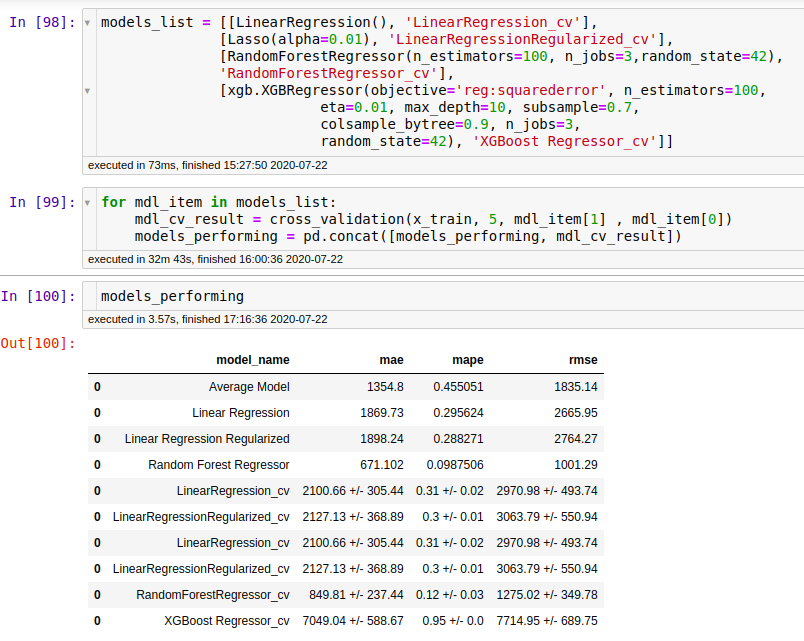

In [103]:
# Image saved from cross validation without tuning

Image('img/performance_models_CV.png')

## 8.0. Hyperparameters Fine Tuning

### 8.1. Random Search

In [114]:

param = {
    'n_estimators': [150, 500, 1500, 2500, 3000],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }
MAX_EVAL = 5

In [ ]:
# prediction time to run is 15 hour

In [105]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    
    #choose values for parameters randomly
    hp = {k: rd.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    
    # loading model randomly parameters
    mdl_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                               n_estimators=hp['n_estimators'],
                               eta=hp['eta'],
                               max_depth=hp['max_depth'],
                               subsample=hp['subsample'], 
                               colsample_bytree=hp['colsample_bytree'],
                               min_child_weight=hp['min_child_weight'])
    
    # get result from prediction with cross validation 
    result_cv = cross_validation(x_train, 5, 'XGBoost Regressor CV', mdl_xgb, True)
    final_result = pd.concat([final_result, result_cv])

{'n_estimators': 150, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}

Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1
{'n_estimators': 150, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}

Kfold Number: 5

Kfold Number: 4

Kfold Number: 3

Kfold Number: 2

Kfold Number: 1


### 8.2. Final Model

In [139]:
#hp = {'n_estimators': 500, 'eta': 0.03, 'max_depth': 9, 
#      'subsample': 0.5, 'colsample_bytree': 0.9, 
#      'min_child_weight': 3}
#
#mdl_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                            n_estimators=hp['n_estimators'],
#                            eta=hp['eta'],
#                            max_depth=hp['max_depth'],
#                            subsample=hp['subsample'], 
#                            colsample_bytree=hp['colsample_bytree'],
#                            min_child_weight=hp['min_child_weight'],
#                            n_jobs=3).fit(x_train.drop(['sales', 'date'], 
#                                                      axis=1), y_train)
#
#y_hat = mdl_xgb.predict(x_test)
#
#xgb_result = ml_error('XGBoost Regressor', expm1(y_test), expm1(y_hat))

In [142]:
#with open('xgb_model_rossmann.pkl', 'wb') as file:
#    pickle.dump(mdl_xgb, file)

In [92]:
with open('xgb_model_rossmann.pkl', 'rb') as file:
    model = pickle.load(file)

y_hat = model.predict(x_test)

result = ml_error('XGBoost Regressor', expm1(y_test), expm1(y_hat))

In [94]:
result

,model_name,mae,mape,rmse
0,XGBoost Regressor,638.98115,0.094513,924.546774


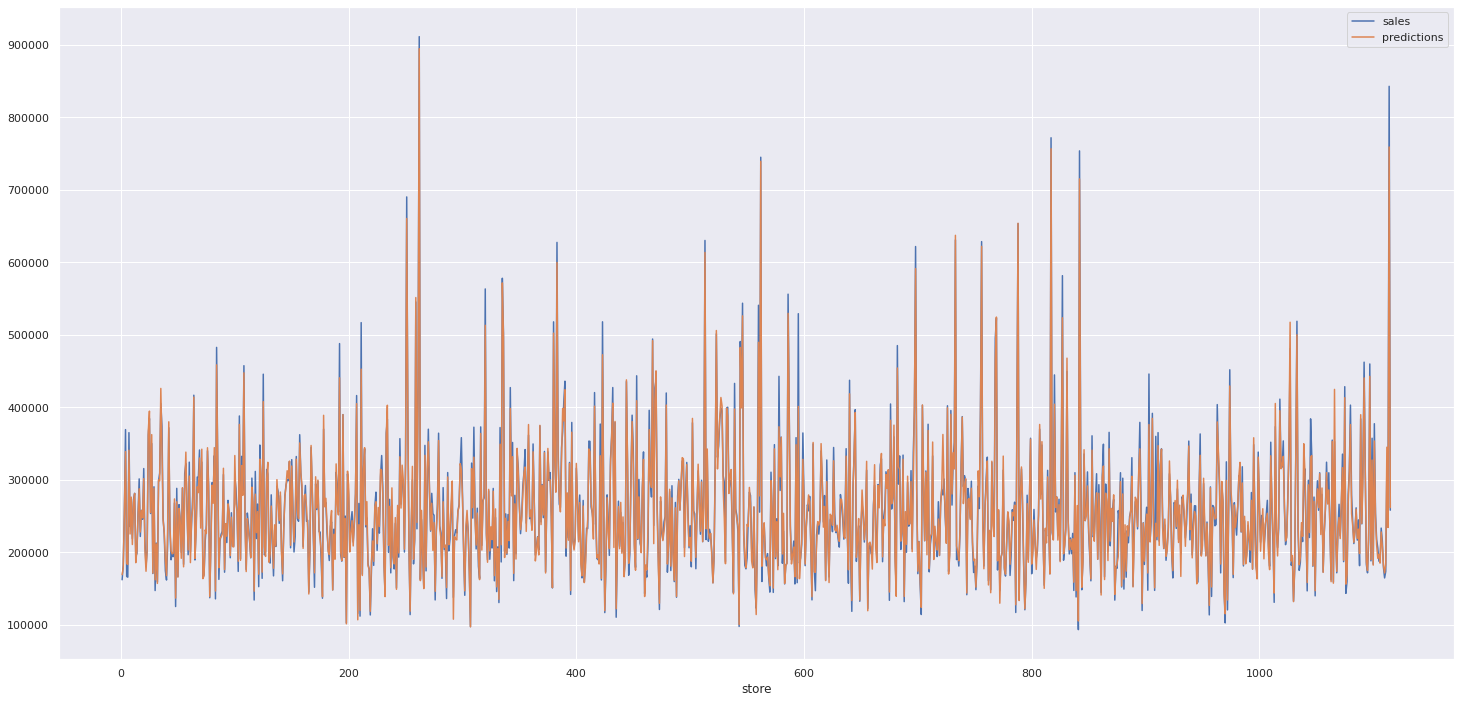

In [93]:
pred_vs_sales = x_test.copy()
pred_vs_sales['sales'] = expm1(y_test).copy()
pred_vs_sales['predictions'] = expm1(y_hat).copy()

# plotting comparison between REAL sales vs PREDICTION sales grouped per store
pred_vs_sales[['store', 'sales', 'predictions']].groupby('store').sum().plot();

In [102]:
aux1 = pred_vs_sales[['store', 'sales', 'predictions']].groupby('store').sum().reset_index()
aux1.head()

,store,sales,predictions
0,1,162320.0,169319.687500
1,2,182936.0,178754.921875
2,3,254190.0,260208.562500
3,4,369378.0,338994.625000
4,5,166905.0,184727.593750
